
**Problem statement and objective**: Study possible anomalies in data of client's transactions. Specifically these transactions are spendings, so an anomaly could indicate that the account has been compromised and therefore the reason for this anomaly would be investigated. <br>
**Author**: Luis Marcos López

In [172]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from datetime import datetime as dt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data loading and basic preprocessing

In [9]:
# Load data and display first few columns
data = pd.read_csv("transaction_data.csv")
display(data.head())

,date,amount,client_id
0,2017-05-24,63.058251,975386
1,2021-08-29,118.253665,955735
2,2020-08-23,102.693555,975386
3,2019-04-27,78.942714,160736
4,2017-10-20,56.949652,143171


In [10]:
# Check data types of columns and total number of values 
data.info()
# Change date column to date format
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
# Get rid of days
data['date'] = data['date'].dt.strftime('%Y-%m')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22239 entries, 0 to 22238
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       22239 non-null  object 
 1   amount     22239 non-null  float64
 2   client_id  22239 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 521.4+ KB


In [11]:
#Display first few columns to see structure of the data
display(data.head())
# Check for NAN and print number of unique values in each column
print("NAN? ", data.isnull().values.any())
print("Unique values: \n\n", data.nunique())

,date,amount,client_id
0,2017-05,63.058251,975386
1,2021-08,118.253665,955735
2,2020-08,102.693555,975386
3,2019-04,78.942714,160736
4,2017-10,56.949652,143171


NAN?  False
Unique values: 

 date            60
amount       22239
client_id       14
dtype: int64


Will focus on the anomalies in transactions of individual clients and not as a whole, because different clients may have different transaction behavior. So, to really understand if there is an anomaly in a client transaction history we have to consider his/her particular behaviour. 

In [12]:
# Identify our clients
clients = data.client_id.unique()
n_clients = len(clients)
print(f"Our clients are: \n {clients}")
print(f"There are a total of {n_clients} unique clients.")

Our clients are: 
 [975386 955735 160736 143171 986180 427729 170552 457867 588453 955698
 966823 169440 589131 499072]
There are a total of 14 unique clients.


Since we are interested in monthly data, we need to convert it from daily to monthly. The key is deciding which statistical indices to use when aggregating:

* On the one hand we want to study possible anomalies in the amount of money spent, so the ***mean*** and ***median*** would be candidates. We choose the mean, since it is more sensitive to outliers than the median. For example, if there has been unusual activity on only one day of the month, the mean will vary more than the median and its identification will be easier.

* On the other hand, we want to study possible anomalies in the number of transactions carried out in a month. In our context, we are interested in whether there have been more transactions than expected, as this could be a sign that the account has been compromised.

In [154]:
df_all = data.groupby(by=[data.date], as_index = False).agg(amount_mean = ('amount', 'mean'), amount_count = ('client_id', 'count')) 
display(df_all.head())

df = data.groupby(by=['client_id', data.date], as_index = False).agg(amount_mean = ('amount', 'mean'), amount_count = ('amount', 'count')) 
display(df.head())

# Transform to date format again
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
df_all['date'] = pd.to_datetime(df_all['date'], format='%Y-%m')
# Get rid of days
# df['date'] = df['date'].dt.strftime('%Y-%m')
display(df.head())

,date,amount_mean,amount_count
0,2017-01,50.011383,70
1,2017-02,66.993297,353
2,2017-03,64.006941,376
3,2017-04,62.998161,369
4,2017-05,63.001105,399


,client_id,date,amount_mean,amount_count
0,143171,2017-01,50.059780,6
1,143171,2017-02,67.008089,27
2,143171,2017-03,64.003178,27
3,143171,2017-04,62.990814,27
4,143171,2017-05,62.980939,28


,client_id,date,amount_mean,amount_count
0,143171,2017-01-01,50.059780,6
1,143171,2017-02-01,67.008089,27
2,143171,2017-03-01,64.003178,27
3,143171,2017-04-01,62.990814,27
4,143171,2017-05-01,62.980939,28


# Focus on client

First of all let's check the scatter plots of the transactions of each client.

## Scatter plots

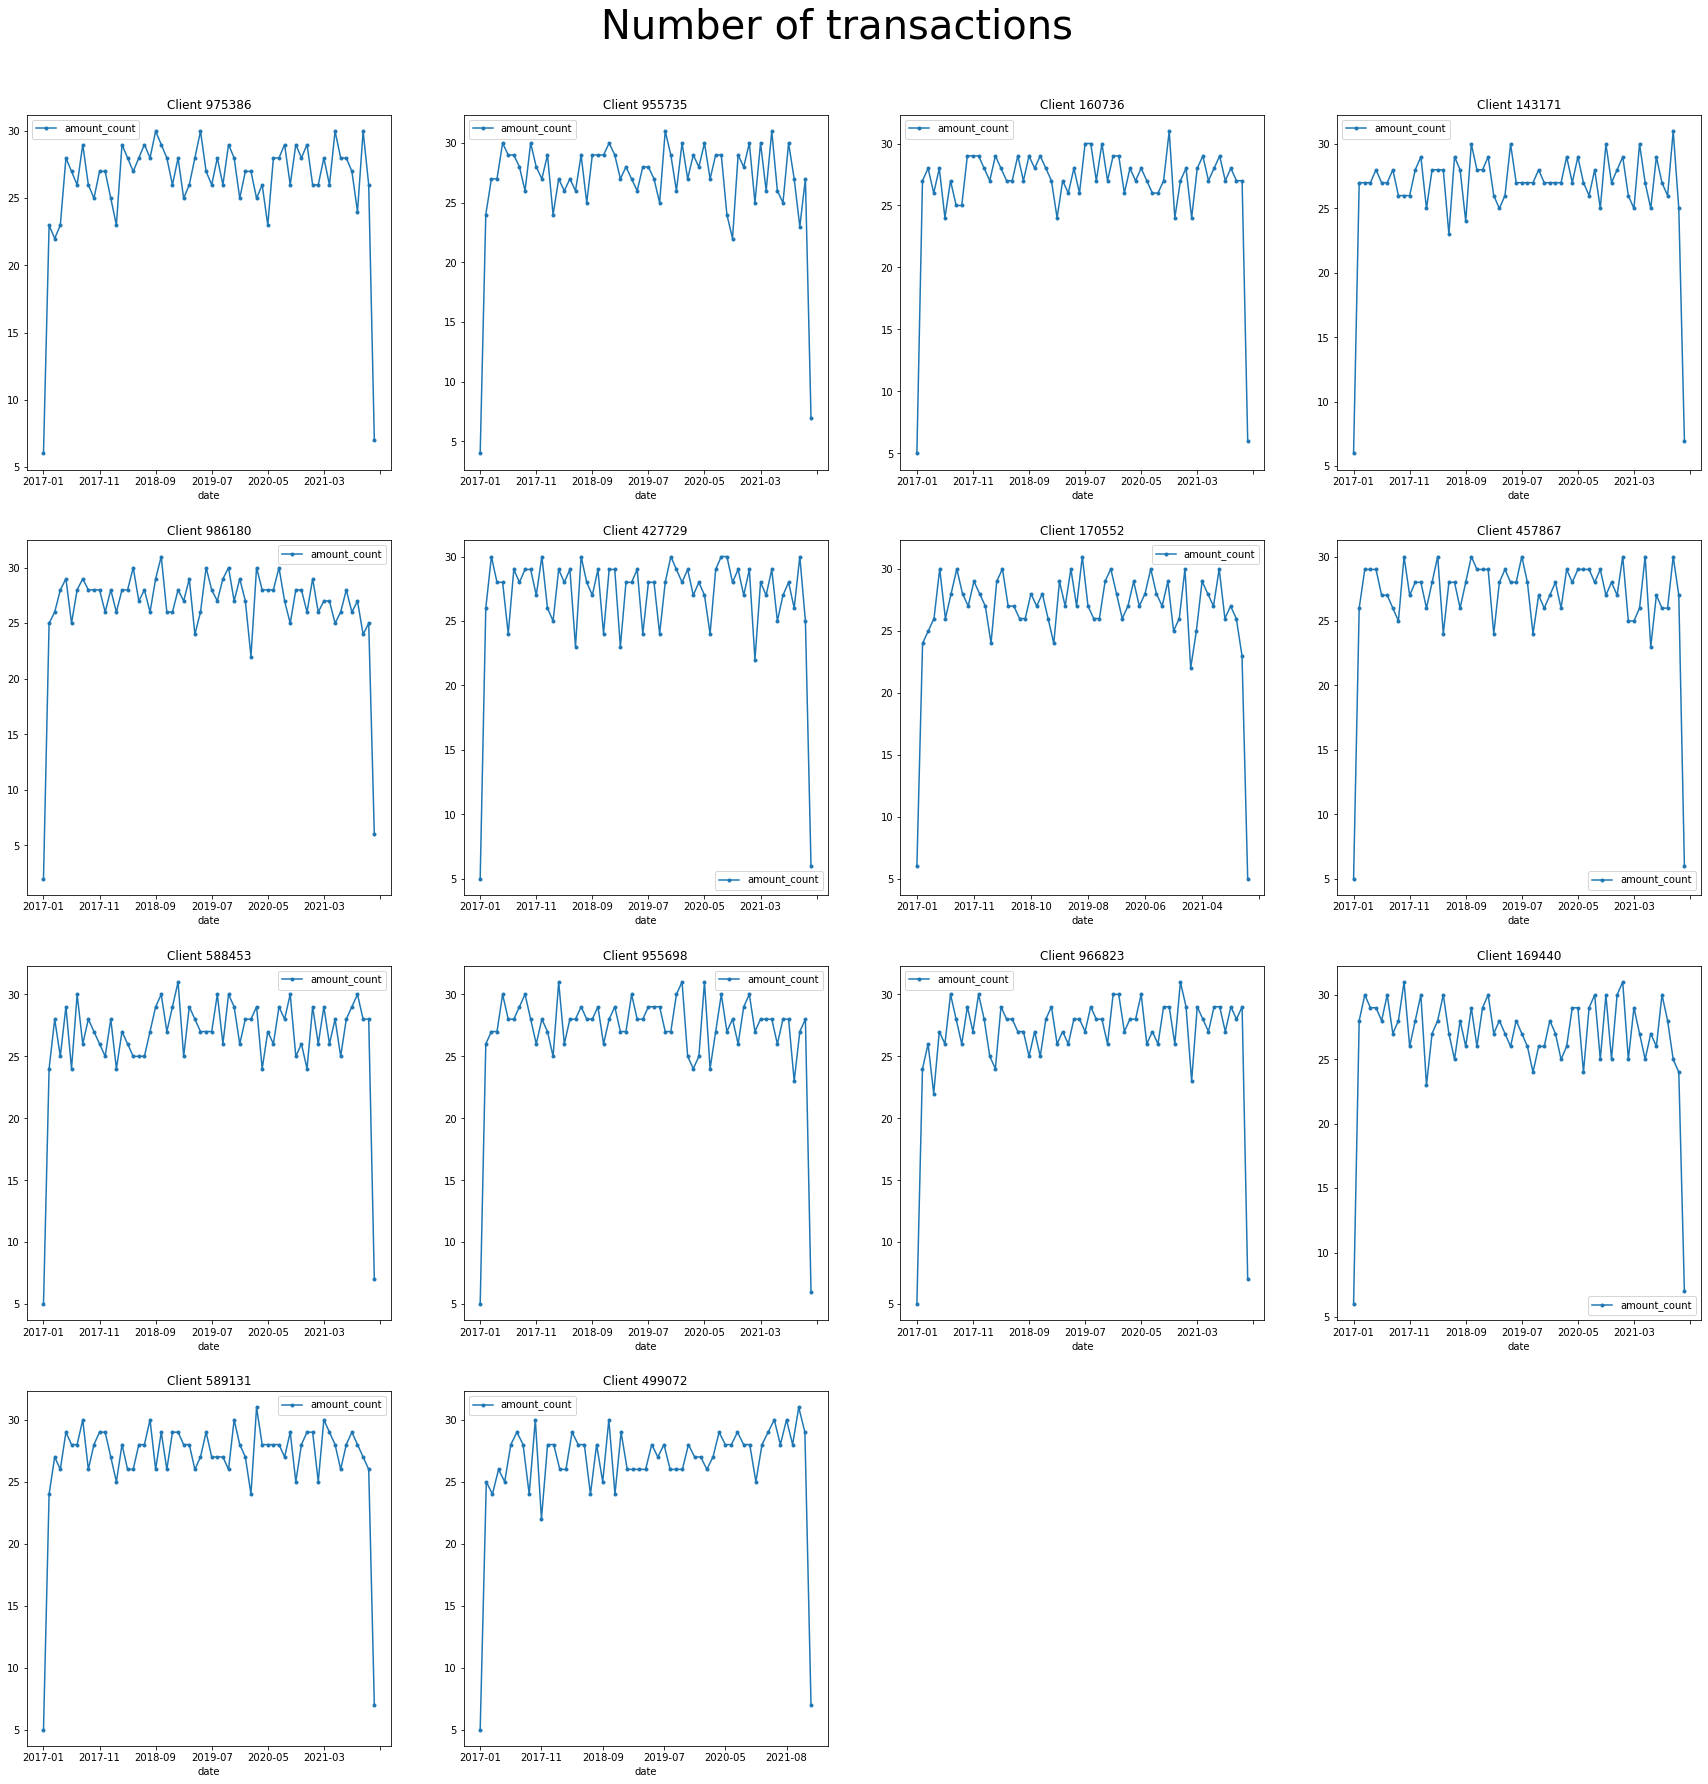

In [10]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))

for i, ax in enumerate(axes.flat):
    if i == n_clients:
        break
    df[df['client_id'] == clients[i]].plot(x= 'date', y= 'amount_count', ax=ax, marker='.')
    ax.set_title('Client {}'.format(clients[i]))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
fig.suptitle('Number of transactions', fontsize=40, y = 0.93)
plt.show()

Something to note here is that the number of transactions are very close to 30-31 which is the maximum number of days in a month and therefore it's impossible to detect anomalies above 31. This is because we have daily data, and clients seem to do some transaction almost daily. 

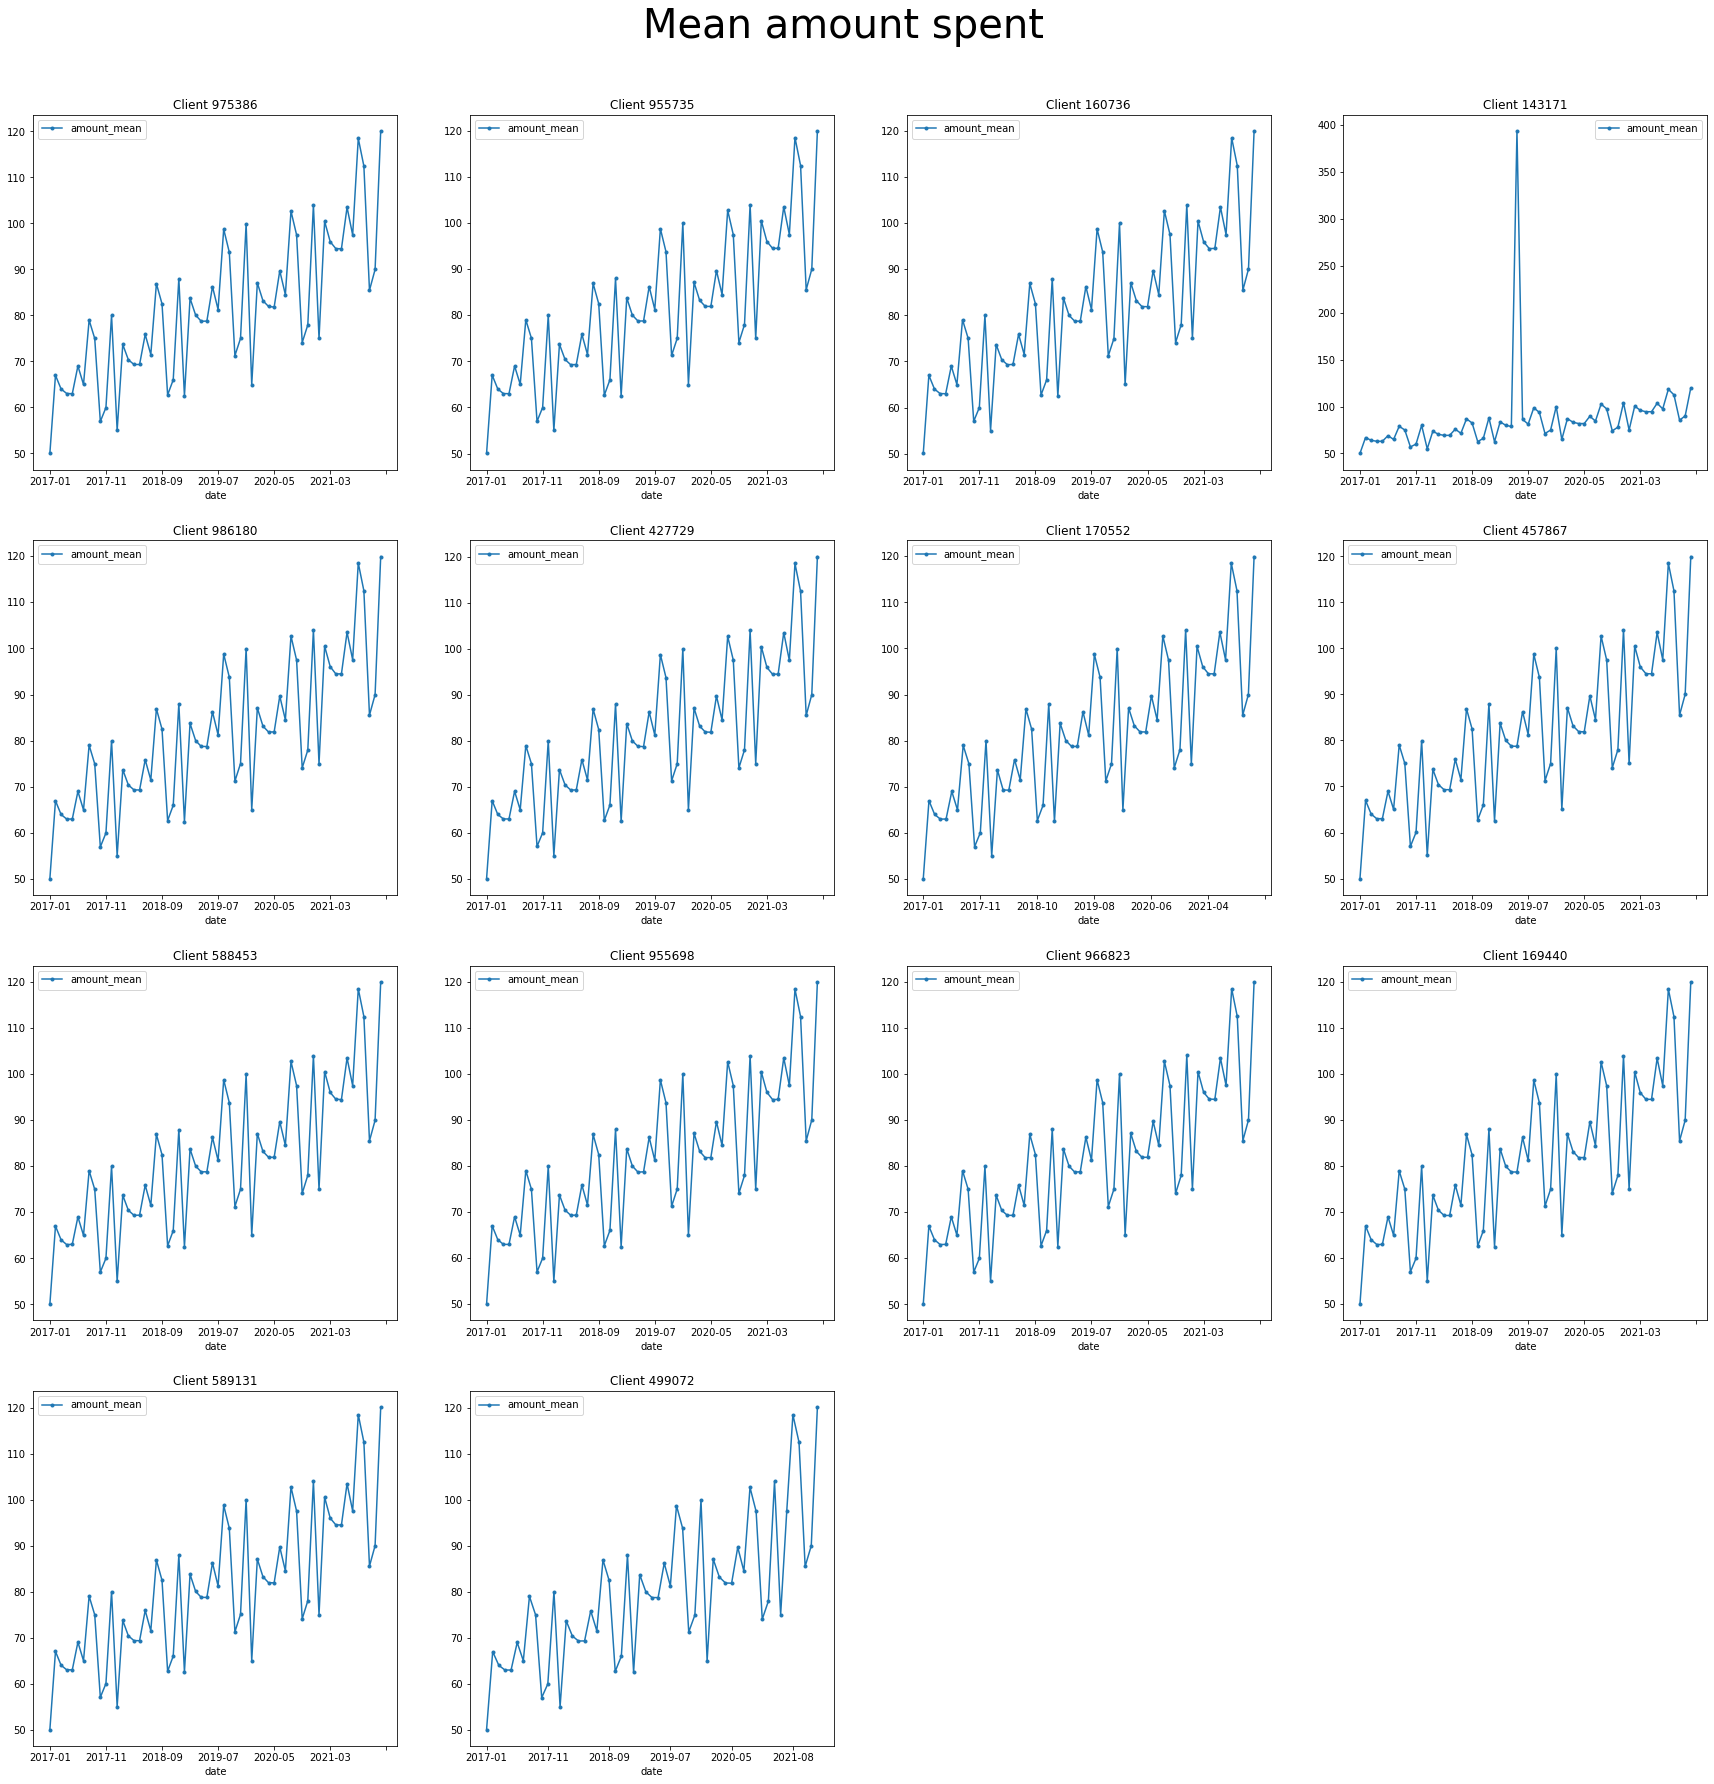

In [11]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))

for i, ax in enumerate(axes.flat):
    if i == n_clients:
        break
    df[df['client_id'] == clients[i]].plot(x= 'date', y= 'amount_mean', ax=ax, marker='.')
    ax.set_title('Client {}'.format(clients[i]))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
fig.suptitle('Mean amount spent', fontsize=40, y = 0.93)
plt.show()

There is a clear outlier for client 143171 when considering the mean of the amount spent. For the rest, there is no clear evidence of outlier.

## Distributions and z score

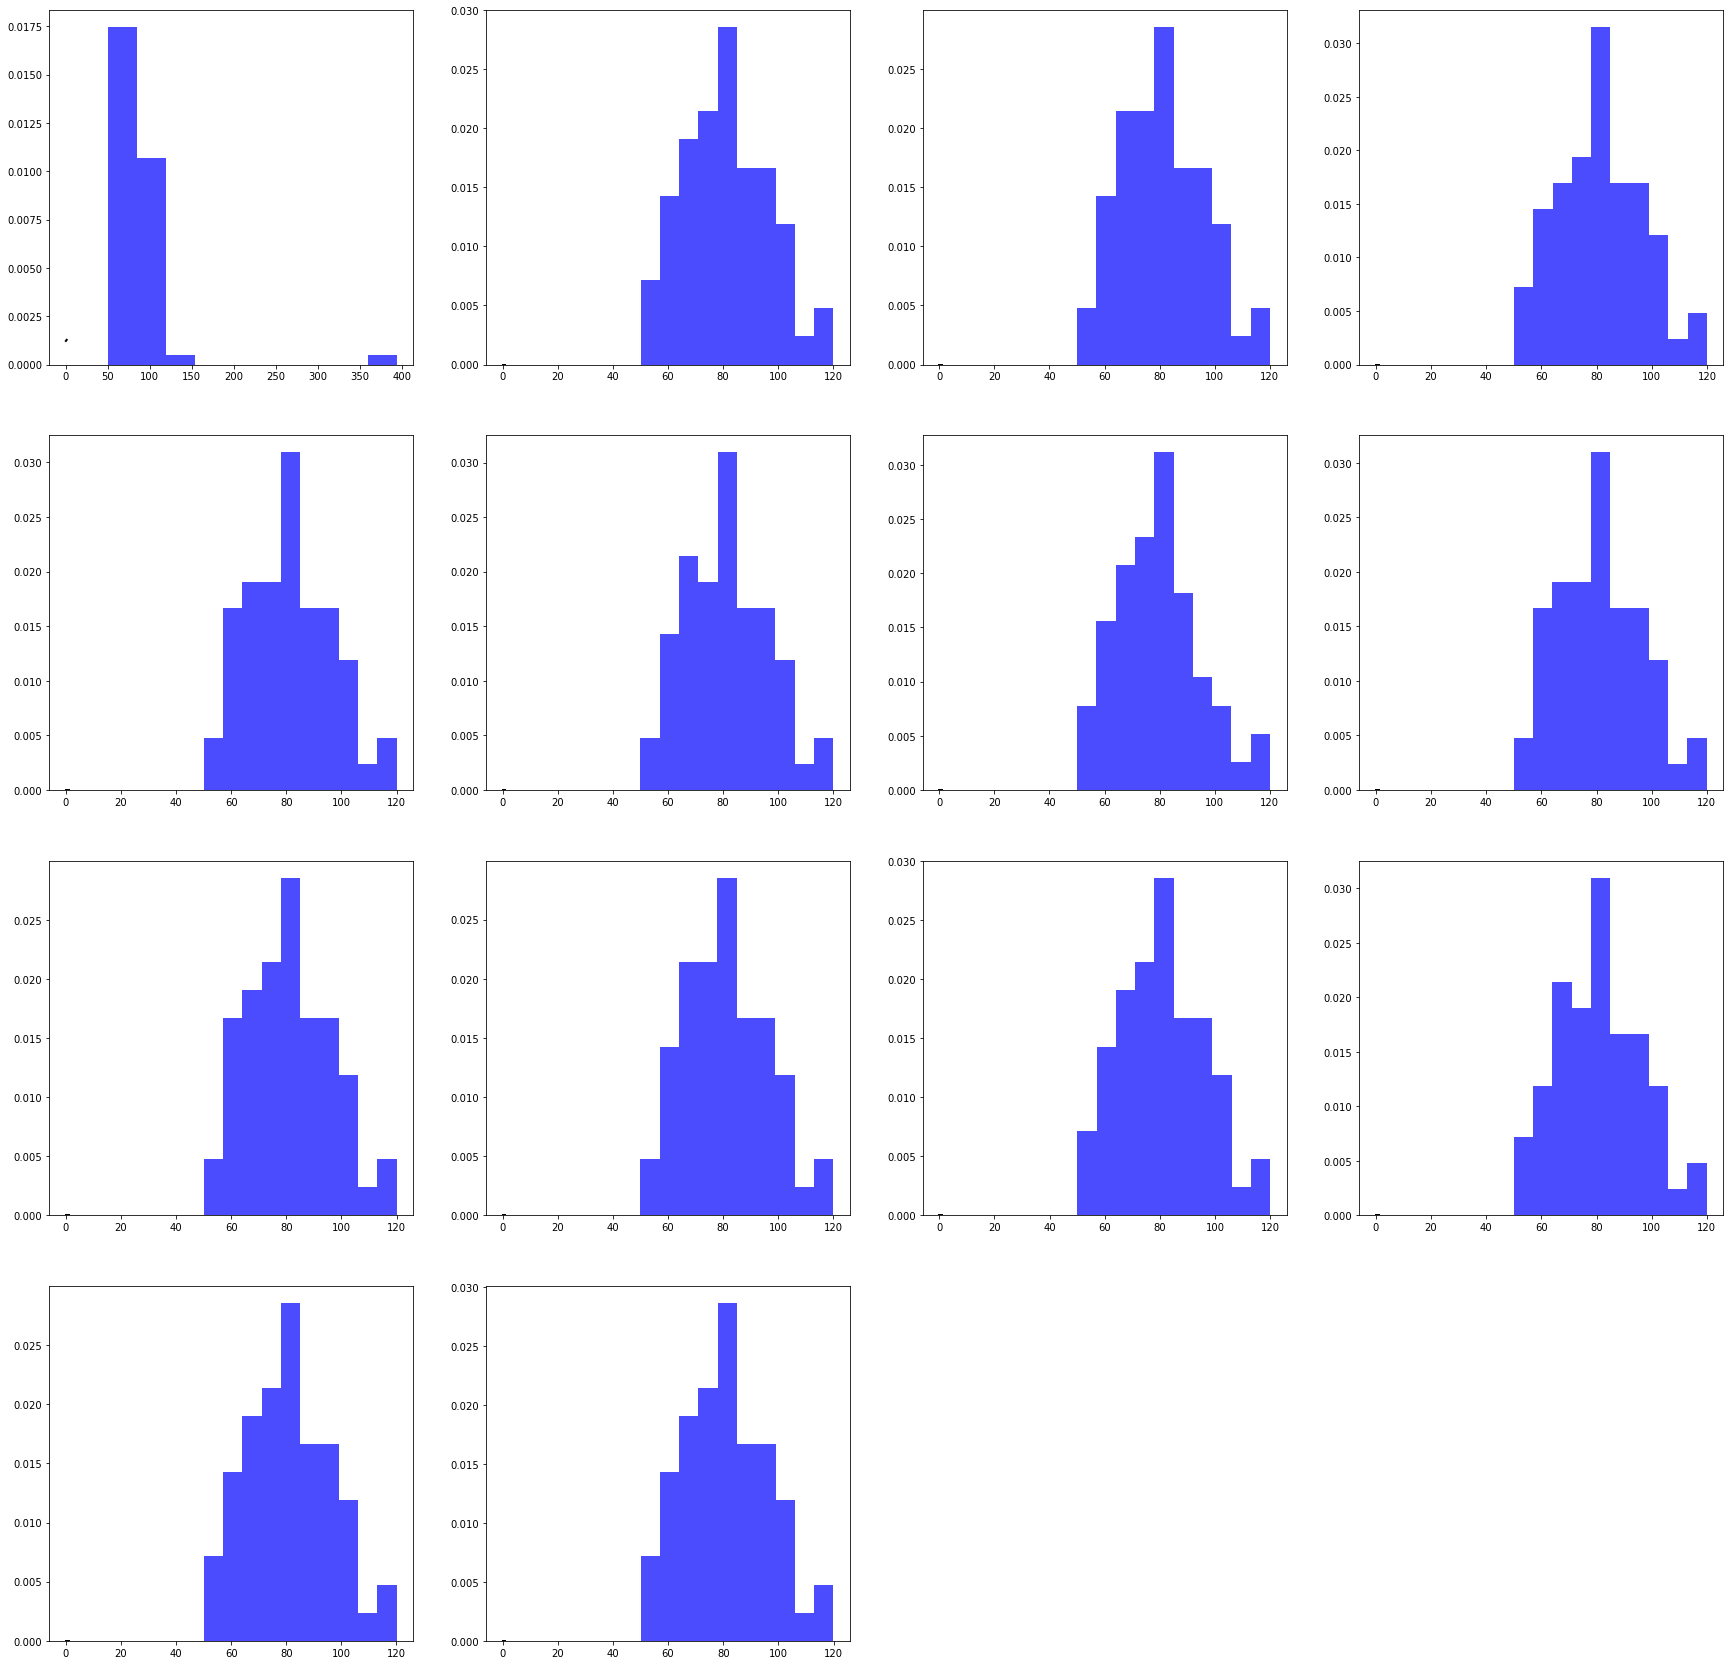

In [12]:
fig, axes = plt.subplots(nrows= 4, ncols=4, figsize = (30,30))

for i, ax in enumerate(axes.flat):
    if i == 14:
        break
    c = df.client_id.unique()[i]
    data_to_plot = df[df['client_id'] == c]['amount_mean']
    mu, std = norm.fit(data_to_plot)
    # Plot the histogram.
    ax.hist(data_to_plot, density=True, alpha=0.7, color='b')

    # Plot the PDF.
    xt = plt.xticks()[0]  
    xmin, xmax = min(xt), max(xt) 
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    # ax.title('Client {}'.format(c))

fig.delaxes(axes[3][3])
fig.delaxes(axes[3][2])
plt.show()


The client spending could be modeled as a gaussian. So let's find those points that lie beyond two sigma standard deviation (z = 2).

In [13]:
def detect_outliers(data, measure):
    """
    Returns which points of a pandas series fall beyond a given z-score threshold. 

    Inputs:
    :data: pandas series from which identifying outliers.
    :measure: name of the pandas series in the dataframe it belongs to. 

    Outputs:
    :outliers: list of identified outliers.

    """
    outliers = []
    threshold = 3
    mean = np.mean(data)
    std =np.std(data)
    
    for i in data:
        z_score = (i - mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(df[df[measure] == i])
    if len(outliers) > 0:
        return outliers


for client in clients:

    current_client = df[df['client_id'] == client]
    # current_client = current_client.set_index('date')

    anomalies_spending = detect_outliers(current_client['amount_mean'], 'amount_mean')
    # anomalies_transactions = detect_outliers(current_client['amount_count'], 'amount_count')

    # # Anomalies in spending amount 
    if anomalies_spending != None:
        print('Anomalies in spending amount'.center(50,'*'))
        for anomaly in anomalies_spending:
            print(anomaly)

 

***********Anomalies in spending amount***********
    client_id     date  amount_mean  amount_count
28     143171  2019-05   393.629502            30


## Boxplots

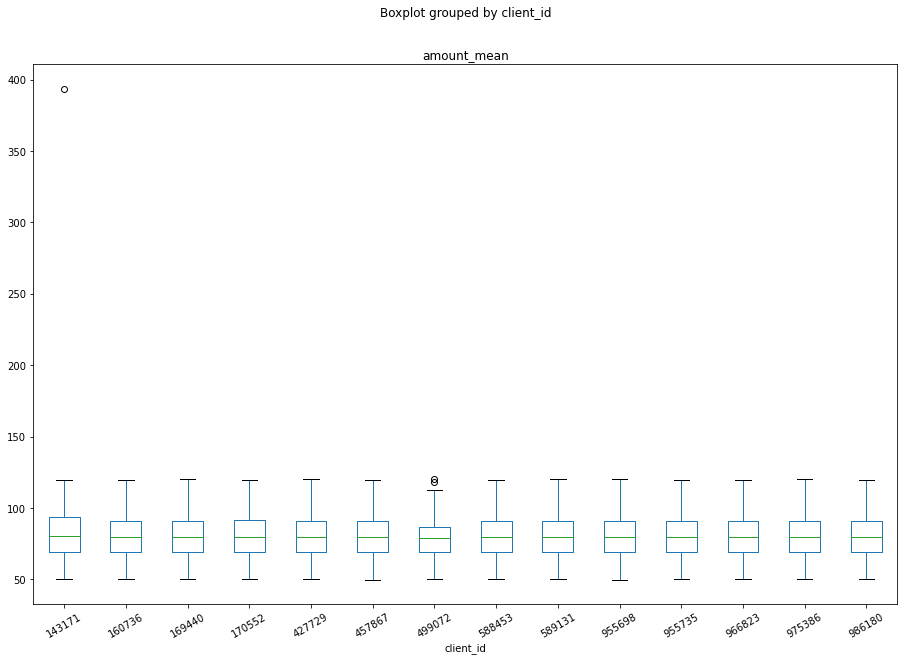

In [14]:
boxplot = df.boxplot(column=['amount_mean'], by='client_id', grid = False, rot = 30, figsize=(15,10))

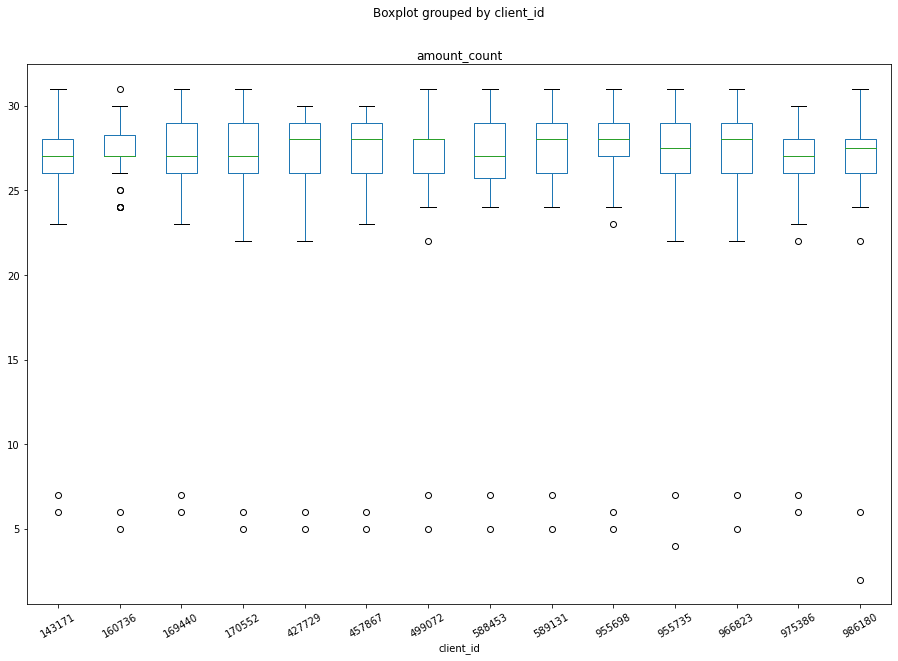

In [15]:
boxplot = df.boxplot(column=['amount_count'], by='client_id', grid = False, rot = 30, figsize=(15,10))

Let's find those outliers

In [16]:
# Print anomalies with regard to spending amount
print("Anomalies with regard to spending amount".center(200,'*'))
for client in clients:
    current_client = df[df['client_id'] == client]
    Q1 = df['amount_mean'].quantile(0.25)
    Q3 = df['amount_mean'].quantile(0.75)
    IQR = Q3 - Q1

    filter = (current_client['amount_mean'] < Q1 - 1.5 * IQR) | (current_client['amount_mean'] > Q3 + 1.5 * IQR)
    # something going on with the boxplots becasue the two outliers for client 499072 are actually inside Q3 + 1.5*IQR, 
    # if we replace 1.5 by 1.3 then we see them:
    # filter = (current_client['amount_mean'] < Q1 - 1.5 * IQR) | (current_client['amount_mean'] > Q3 + 1.3 * IQR) 
    if filter.any():
        display(current_client.loc[filter])

# Print anomalies with regard to number of transactions
print("Anomalies with regard to number of transactions".center(200,'*'))
for client in clients:
    current_client = df[df['client_id'] == client]
    Q1 = df['amount_count'].quantile(0.25)
    Q3 = df['amount_count'].quantile(0.75)
    IQR = Q3 - Q1

    filter = ((current_client['amount_count'] < Q1 - 1.5 * IQR) | (current_client['amount_count'] > Q3 + 1.5 * IQR))
    if filter.any():
        display(current_client.loc[filter])

********************************************************************************Anomalies with regard to spending amount********************************************************************************


,client_id,date,amount_mean,amount_count
28,143171,2019-05,393.629502,30


****************************************************************************Anomalies with regard to number of transactions*****************************************************************************


,client_id,date,amount_mean,amount_count
714,975386,2017-01,50.006612,6
773,975386,2021-12,120.073902,7


,client_id,date,amount_mean,amount_count
594,955735,2017-01,50.038410,4
653,955735,2021-12,119.918954,7


,client_id,date,amount_mean,amount_count
60,160736,2017-01,50.047809,5
119,160736,2021-12,119.973821,6


,client_id,date,amount_mean,amount_count
0,143171,2017-01,50.059780,6
59,143171,2021-12,119.954088,7


,client_id,date,amount_mean,amount_count
774,986180,2017-01,50.054940,2
833,986180,2021-12,119.916524,6


,client_id,date,amount_mean,amount_count
239,427729,2017-01,49.994316,5
298,427729,2021-12,120.037550,6


,client_id,date,amount_mean,amount_count
180,170552,2017-01,50.041918,6
238,170552,2021-12,119.931829,5


,client_id,date,amount_mean,amount_count
299,457867,2017-01,49.933823,5
358,457867,2021-12,119.972596,6


,client_id,date,amount_mean,amount_count
414,588453,2017-01,50.023051,5
473,588453,2021-12,119.987704,7


,client_id,date,amount_mean,amount_count
534,955698,2017-01,49.949088,5
593,955698,2021-12,120.041505,6


,client_id,date,amount_mean,amount_count
654,966823,2017-01,50.01952,5
713,966823,2021-12,119.95577,7


,client_id,date,amount_mean,amount_count
120,169440,2017-01,49.986236,6
179,169440,2021-12,120.064968,7


,client_id,date,amount_mean,amount_count
474,589131,2017-01,49.986093,5
533,589131,2021-12,120.039410,7


,client_id,date,amount_mean,amount_count
359,499072,2017-01,50.039501,5
413,499072,2021-12,120.077164,7


## Seasonal method

Based on the scatter plots previously plotted we know there is some seasonality in our data. Let's look now at the standard deviation of datapoints within a given month. So, we assume January is correlated with January, Febrary with February and so on.

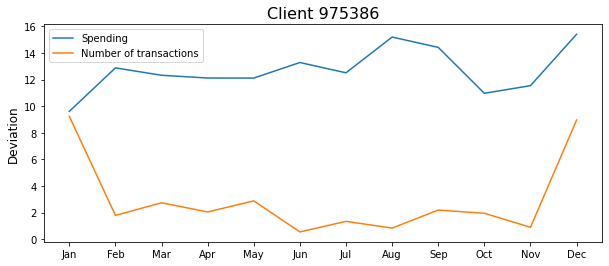

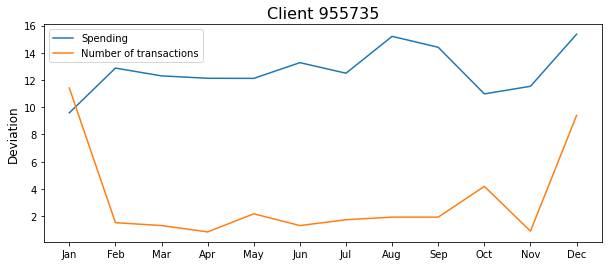

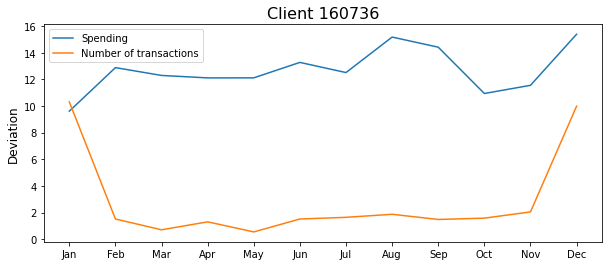

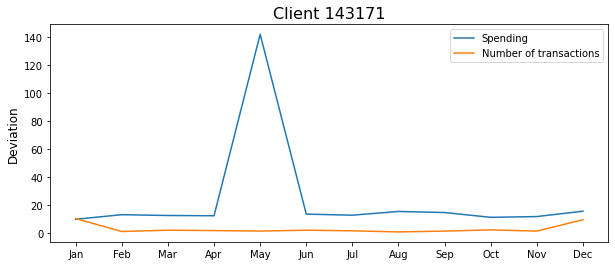

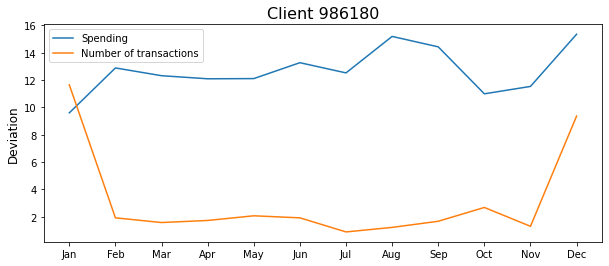

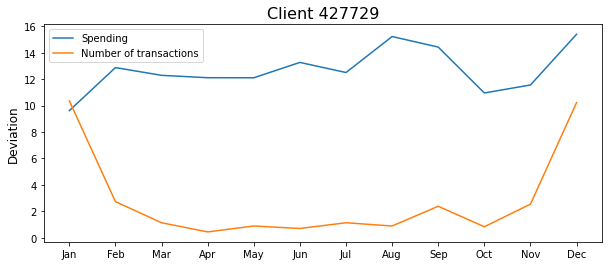

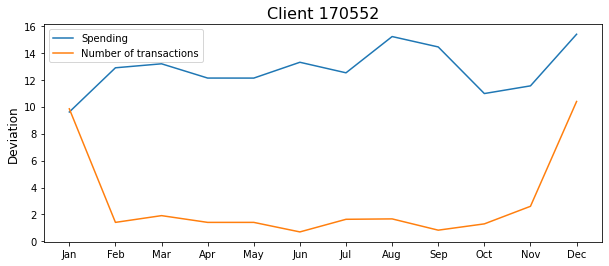

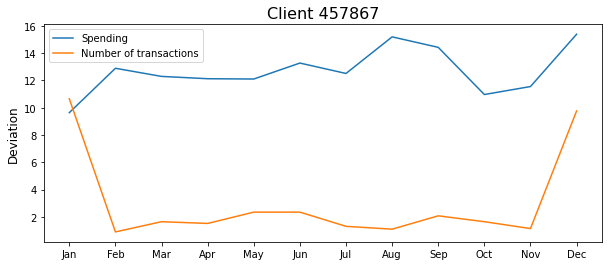

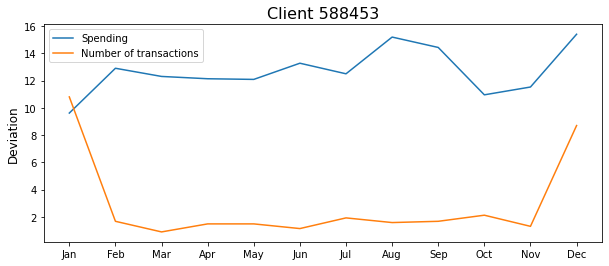

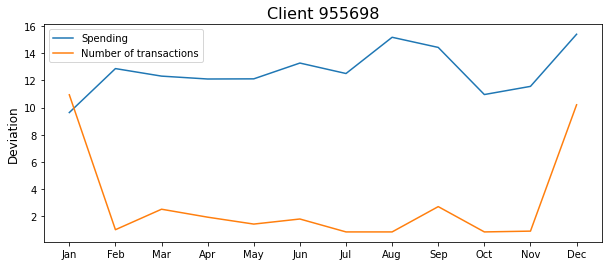

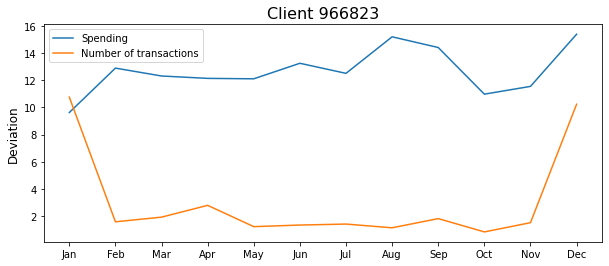

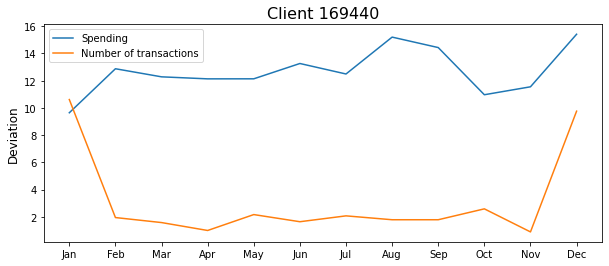

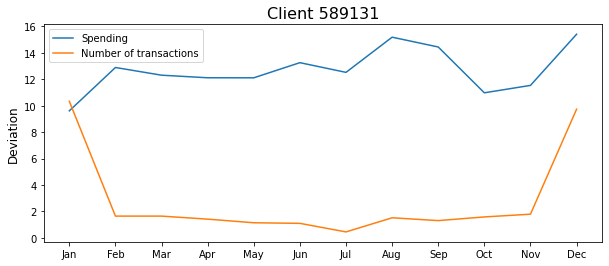

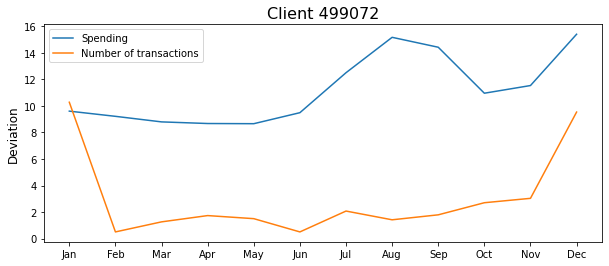

In [150]:
for client in clients:
    current_client = df[df['client_id'] == client]
    month_deviations_spending = current_client.groupby(by=[current_client.date.dt.month], as_index = False).agg(deviations = ('amount_mean', 'std')) 
    month_deviations_transactions = current_client.groupby(by=[current_client.date.dt.month], as_index = False).agg(deviations = ('amount_count', 'std'))

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    xi = list(range(len(months)))

    plt.figure(figsize=(10,4))
    plt.plot(month_deviations_spending, label = 'Spending')
    plt.plot(month_deviations_transactions, label = 'Number of transactions')
    plt.title(f'Client {client}', fontsize=16)
    plt.ylabel('Deviation', fontsize=12)
    plt.xticks(xi, months)
    plt.legend()

We can see again the very clear outlier for client 143171, which correspond to April. Now, we would have to chech which of the standard deviations of the months of April is not in line with the others. But we have already identified this anomaly before. For client 499072 the deviation behaves slightly different than for the rest of the clients, but it's still moving inside the expected range of deviation.

## Rolling standard deviation

This method calculates the standard deviation of increasing windows of datapoints. We want to see if the standard deviation is generally steady. If at some point the value deviates there coulñd be an anomaly at that point. This method is not very robust since for the first datapoints the calculation of the standard deviation is only based on few points. Therefore we can't look for anomalies in the first few values. 

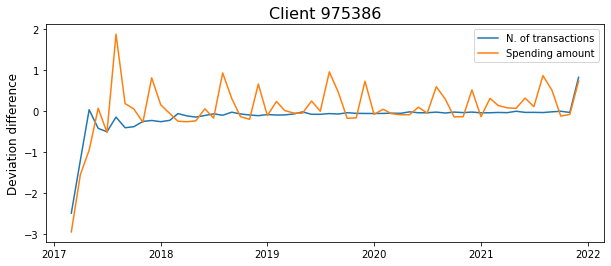

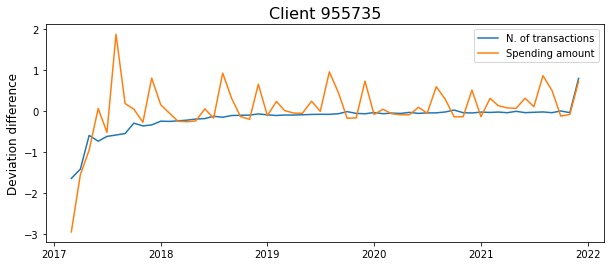

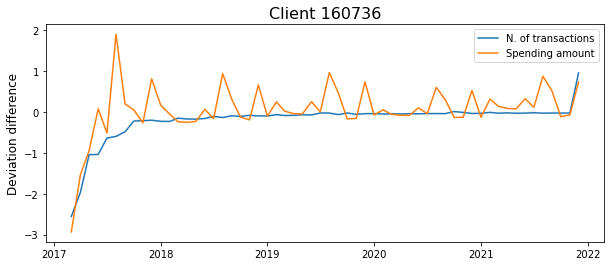

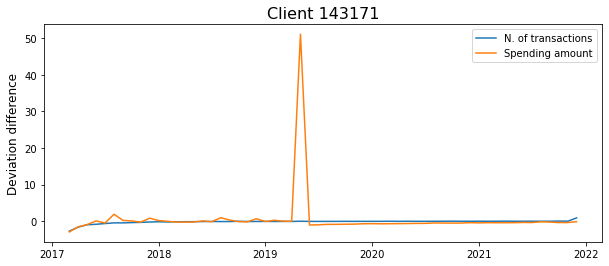

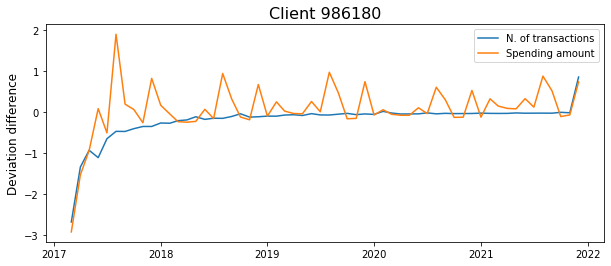

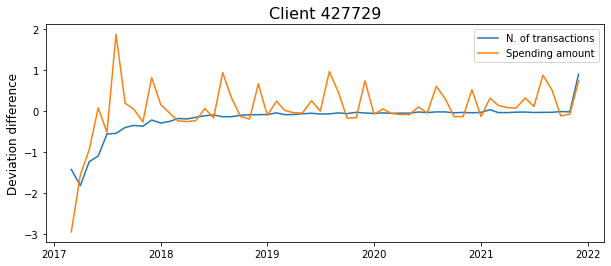

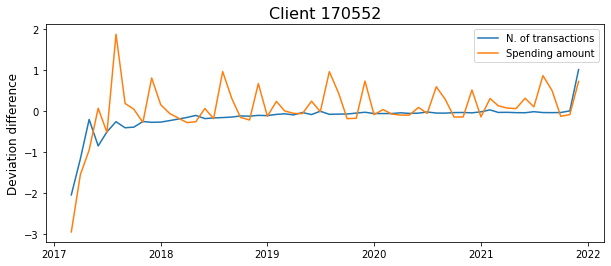

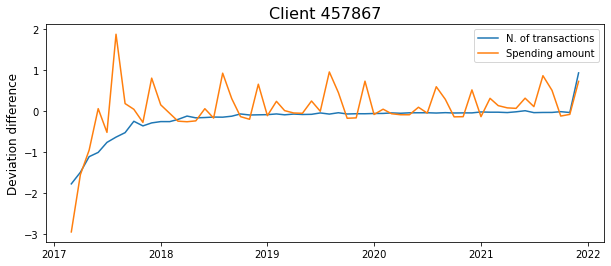

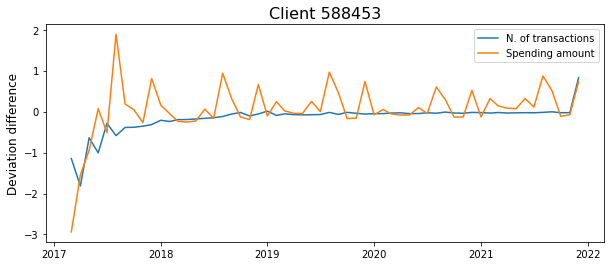

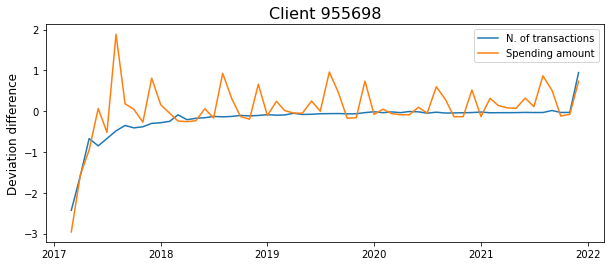

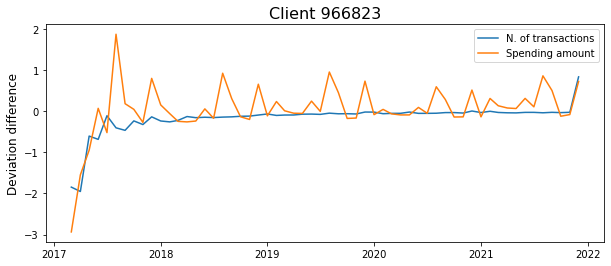

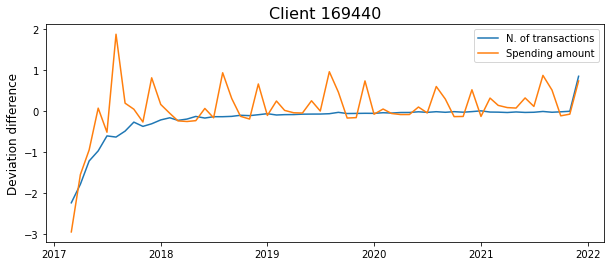

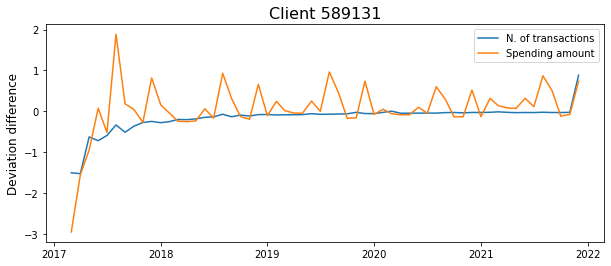

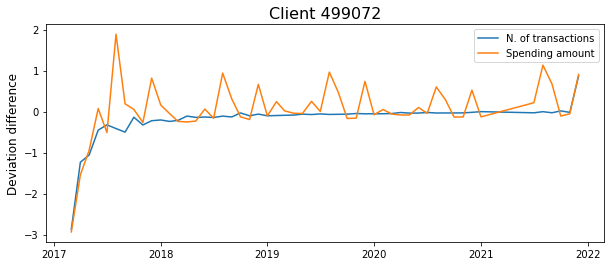

In [149]:
for client in clients:
    current_client = df[df['client_id'] == client]

    rolling_deviations_spend = pd.Series(dtype=float, index = current_client.index)
    rolling_deviations_transact = pd.Series(dtype=float, index = current_client.index)

    for date in rolling_deviations_spend.index:
        #get the window ending at this data point
        window_s = current_client['amount_mean'].loc[:date]
        window_t = current_client['amount_count'].loc[:date]
        
        #get the deviation within this window
        rolling_deviations_spend.loc[date] = window_s.std()
        rolling_deviations_transact.loc[date] = window_t.std()


    #get the difference in deviation between one time point and the next
    diff_rolling_deviations_s = rolling_deviations_spend.diff()
    diff_rolling_deviations_s = diff_rolling_deviations_s.dropna()

    diff_rolling_deviations_t = rolling_deviations_transact.diff()
    diff_rolling_deviations_t = diff_rolling_deviations_t.dropna() 
    

    plt.figure(figsize=(10,4))
    plt.plot(current_client.date[2:], diff_rolling_deviations_t.iloc[:], label = "N. of transactions")
    plt.plot(current_client.date[2:], diff_rolling_deviations_s,  label = "Spending amount")
    plt.title(f'Client {client}', fontsize=16)
    plt.ylabel('Deviation difference', fontsize=12)
    plt.legend()

## LST decomposition

In [298]:
def find_anomalies(current_client, resid, client):
    """
    Calculates outliers from residuals of a time series. First identifies which residuals lie beyond
    3 std, then identifies which residuals fall outside 1.5 IQR. Prints and plots the identified ouliers. 

    Inputs:
    :current_client: Pandas series corresponding to one client's mean spending amount. Index is the date
    :resid: Pandas series of resiudals extracted from the fit of current_client to an STL model. 
    :client: client number corresponding to the current_client series.
    """


    # calculate needed quantities for z-score analysis of residuals
    resid_mu = resid.mean()
    resid_dev = resid.std()
    lower = resid_mu - 3*resid_dev
    upper = resid_mu + 3*resid_dev

    # calculate needed quantities for IQR analysis of residuals
    Q1 = resid.quantile(0.25)
    Q3 = resid.quantile(0.75)
    IQR = Q3 - Q1
    lower_iqr = Q1 - 1.5 * IQR
    upper_iqr = Q3 + 1.5 * IQR


    # Plot residuals with confidence band
    plt.figure(figsize=(10,4))
    plt.plot(resid, marker='.')

    plt.fill_between([dt(2017,1,1), dt(2021,12,1)], lower, upper, color='g', alpha=0.2, linestyle='--', linewidth=2, label= "z-score" )
    plt.fill_between([dt(2017,1,1), dt(2021,12,1)], lower_iqr, upper_iqr, color='g', alpha=0.4, linestyle='--', linewidth=2, label= "IQR")
    # plt.text(dt(2017,4,1), 1.1*upper_iqr, "IQR", ha='center', va='center', fontsize=12, color='crimson')
    # plt.text(dt(2017,4,1), 1.05*upper, "z-score", ha='center', va='center', fontsize=12, color='crimson')
    plt.title(f"Client {client}")
    plt.legend()

    print("#".center(50, '#'))
    print(f" Client {client} ".center(50, '#'))
    print("#".center(50, '#'))


    # print anomalies found with z-score
    anomalies = current_client[(resid < lower) | (resid > upper)]
    print("Anomalies found with z-score".center(50,'*'))
    display(anomalies)


    # print anomalies found with IQR
    filter = (resid < Q1 - 1.5 * IQR) | (resid > Q3 + 1.5 * IQR)
    print("Anomalies found with IQR".center(50,'*'))
    if filter.any():
        display(current_client.loc[filter])


    # Plot data with identified residuals
    plt.figure(figsize=(10,4))
    plt.plot(current_client.index, current_client.iloc[:], marker='.')   
    plt.scatter(current_client.loc[filter].index, current_client.loc[filter].iloc[:], s = 120, color='r', marker='*', alpha = 0.8, label = "IQR")
    plt.scatter(anomalies.index, anomalies.iloc[:], s = 120, color='lime', marker='*', alpha = 0.7, label = "z-score")
    plt.title(f"Client {client}")
    plt.legend()
    plt.show()


##################################################
################# Client 975386 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.951757
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.951757
2020-02-01    87.082803
Name: amount_mean, dtype: float64

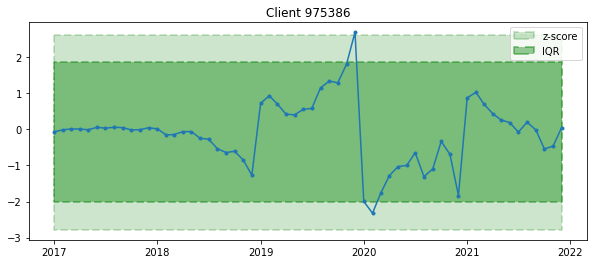

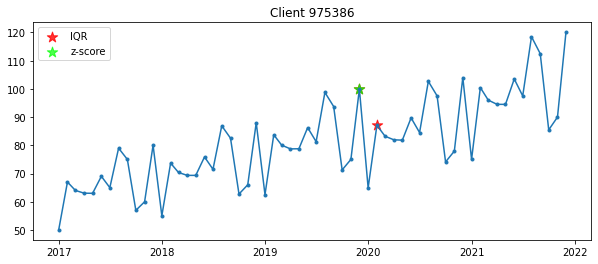

##################################################
################# Client 955735 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.996159
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.996159
2020-02-01    87.129594
Name: amount_mean, dtype: float64

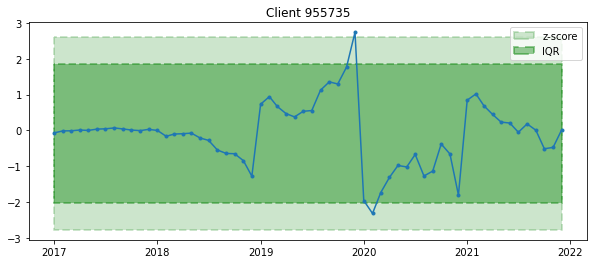

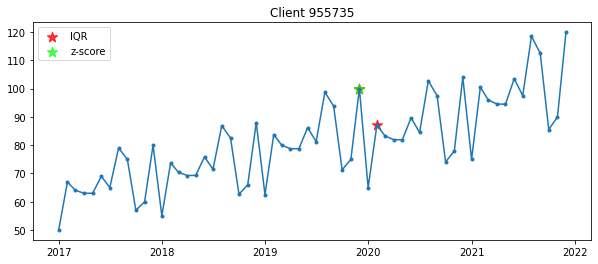

##################################################
################# Client 160736 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.989454
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.989454
2020-02-01    87.102976
Name: amount_mean, dtype: float64

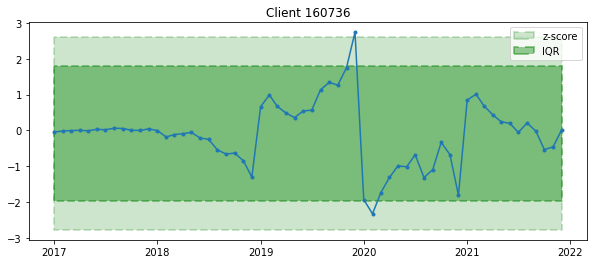

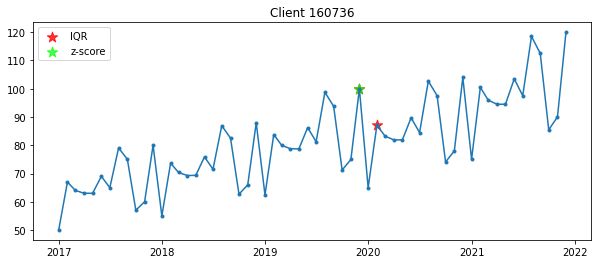

##################################################
################# Client 143171 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-05-01    393.629502
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2017-05-01     62.980939
2018-05-01     69.334119
2019-05-01    393.629502
2020-05-01     81.870210
2021-05-01     94.510483
Name: amount_mean, dtype: float64

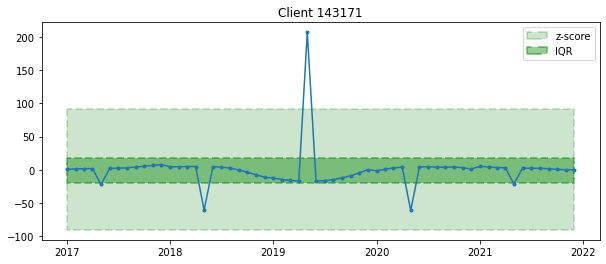

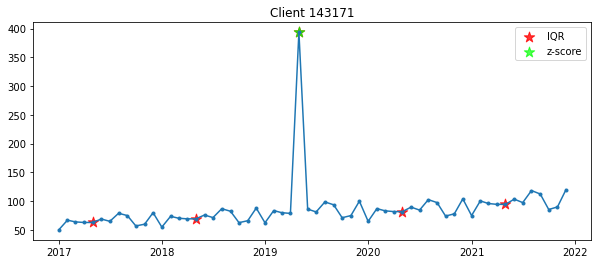

##################################################
################# Client 986180 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.973044
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.973044
2020-02-01    87.099877
Name: amount_mean, dtype: float64

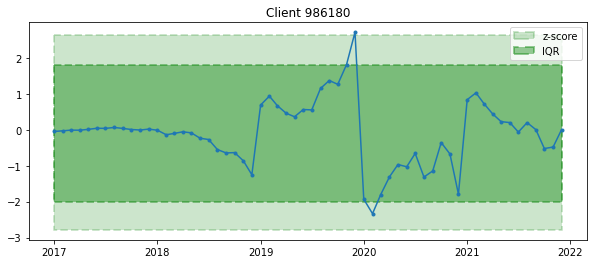

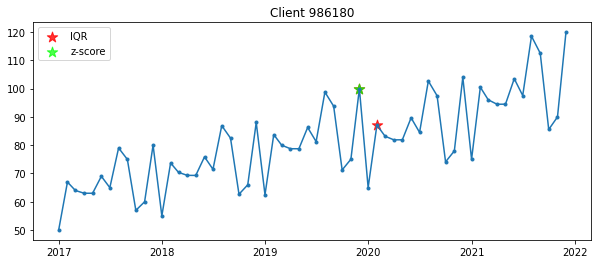

##################################################
################# Client 427729 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.986198
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.986198
2020-01-01    64.966645
2020-02-01    87.116535
Name: amount_mean, dtype: float64

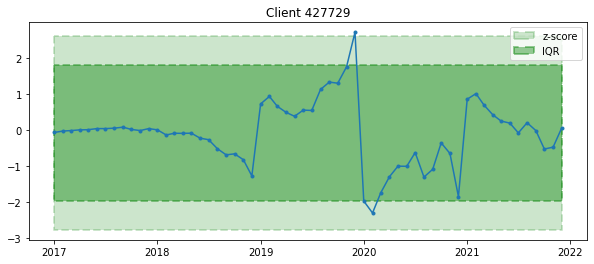

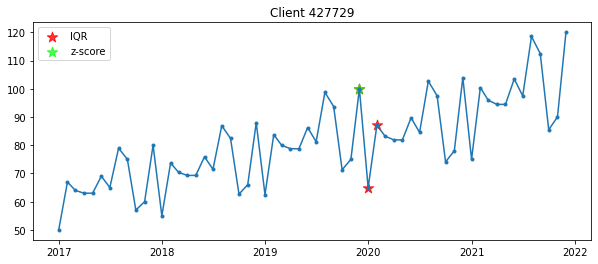

##################################################
################# Client 170552 ##################
##################################################
***********Anomalies found with z-score***********


Series([], Name: amount_mean, dtype: float64)

*************Anomalies found with IQR*************


date
2017-09-01    75.007041
2017-11-01    60.027616
2017-12-01    79.985377
2018-01-01    55.017122
2018-08-01    86.890768
2018-10-01    62.689813
2018-12-01    88.010196
2019-01-01    62.510889
2019-02-01    83.763060
2019-12-01    99.977995
Name: amount_mean, dtype: float64

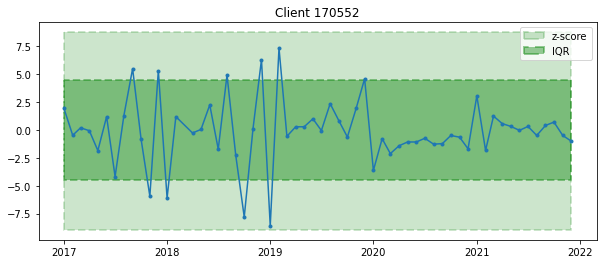

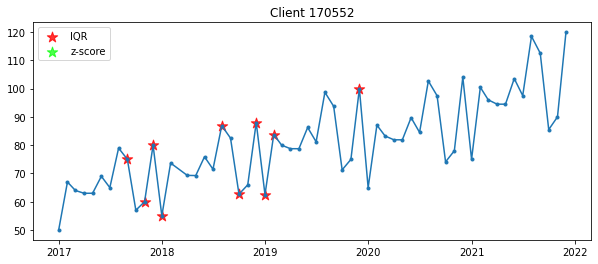

##################################################
################# Client 457867 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.990255
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.990255
2020-02-01    87.133130
Name: amount_mean, dtype: float64

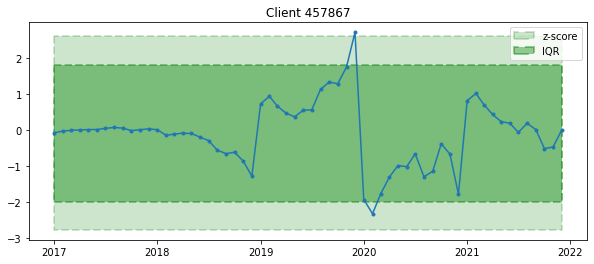

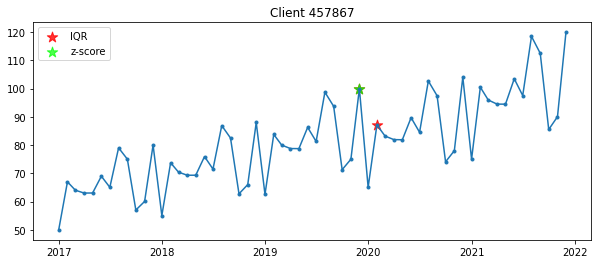

##################################################
################# Client 588453 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.960967
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.960967
2020-02-01    87.086437
Name: amount_mean, dtype: float64

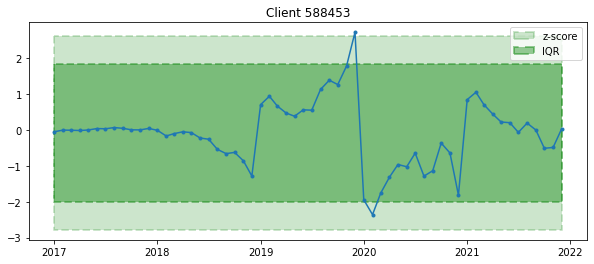

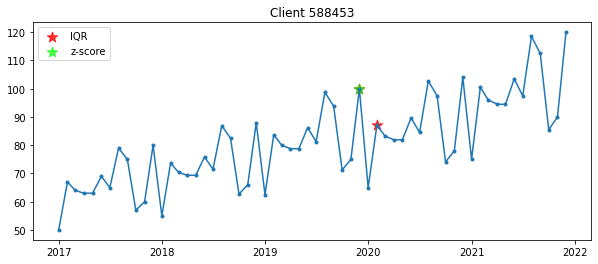

##################################################
################# Client 955698 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    100.034268
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    100.034268
2020-02-01     87.143776
Name: amount_mean, dtype: float64

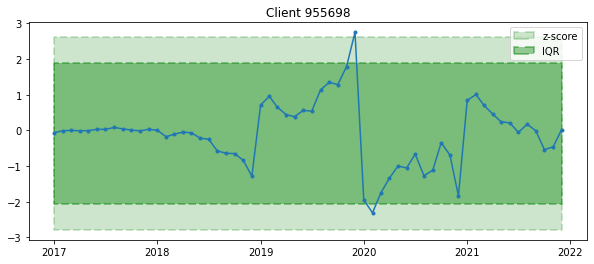

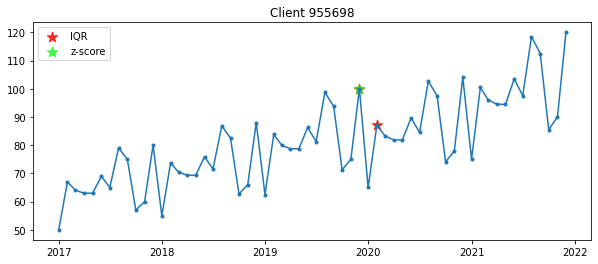

##################################################
################# Client 966823 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    100.03622
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    100.036220
2020-02-01     87.110353
Name: amount_mean, dtype: float64

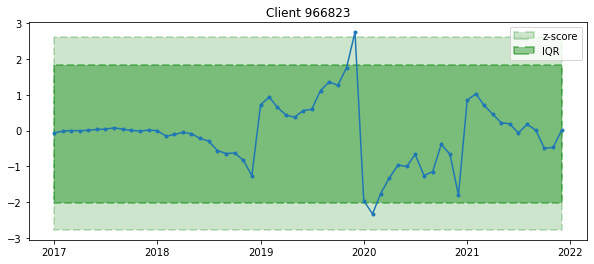

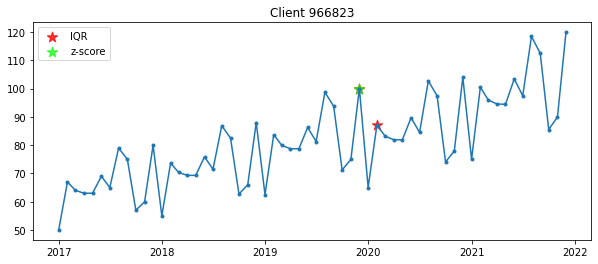

##################################################
################# Client 169440 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    99.9929
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    99.99290
2020-02-01    87.07727
Name: amount_mean, dtype: float64

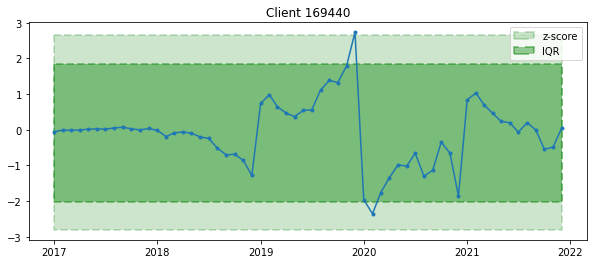

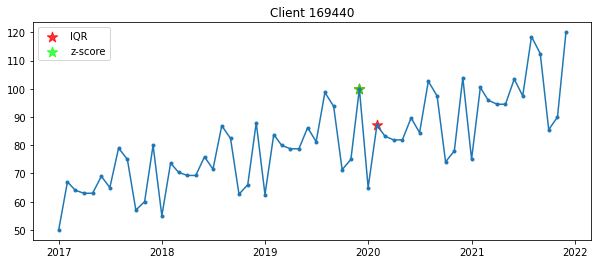

##################################################
################# Client 589131 ##################
##################################################
***********Anomalies found with z-score***********


date
2019-12-01    100.004077
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2019-12-01    100.004077
2020-02-01     87.084100
Name: amount_mean, dtype: float64

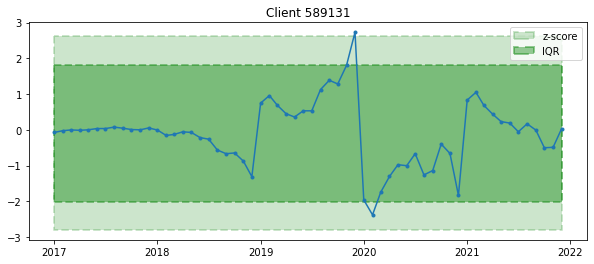

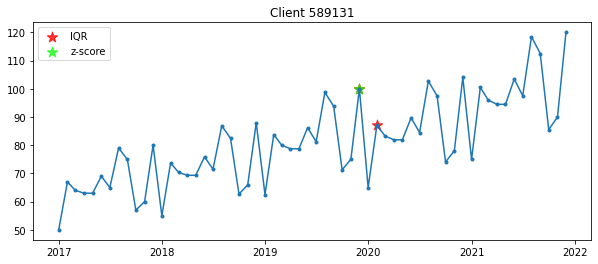

##################################################
################# Client 499072 ##################
##################################################
***********Anomalies found with z-score***********


date
2020-03-01    83.194457
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2020-03-01     83.194457
2020-04-01     81.917480
2020-06-01     89.676219
2020-07-01     84.493628
2021-08-01    118.481263
2021-09-01    112.508136
2021-11-01     90.014669
2021-12-01    120.077164
Name: amount_mean, dtype: float64

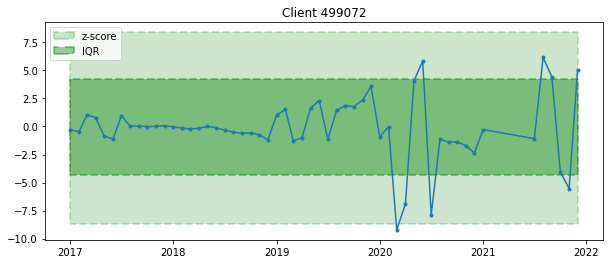

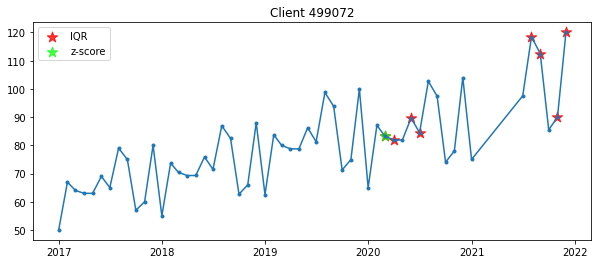

In [299]:
for client in clients:
    current_client = df[df['client_id'] == client].set_index('date')['amount_mean']

    stl = STL(current_client, period = 12)
    result = stl.fit()
    resid = result.resid

    find_anomalies(current_client, resid, client)

## Isolation forest

Isolation forests are based on the idea that decision trees isolate an outlier easier than a inlier. So we are likely to find the outliers closer to the root. 

![image info](https://www.researchgate.net/publication/352017898/figure/fig1/AS:1029757483372550@1622524724599/Isolation-Forest-learned-iForest-construction-for-toy-dataset.png)

We are going to train the isolation forest with a a contamination of 1\%, which means it will give use the most likely outlier for each client transaction history. 

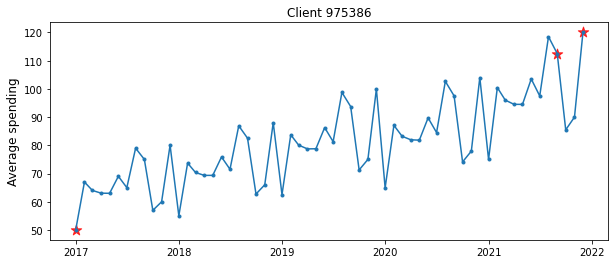

,client_id,date,amount_mean,amount_count
714,975386,2017-01-01,50.006612,6
770,975386,2021-09-01,112.477220,24
773,975386,2021-12-01,120.073902,7


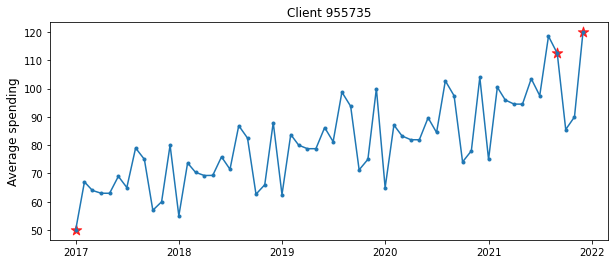

,client_id,date,amount_mean,amount_count
594,955735,2017-01-01,50.038410,4
650,955735,2021-09-01,112.457208,27
653,955735,2021-12-01,119.918954,7


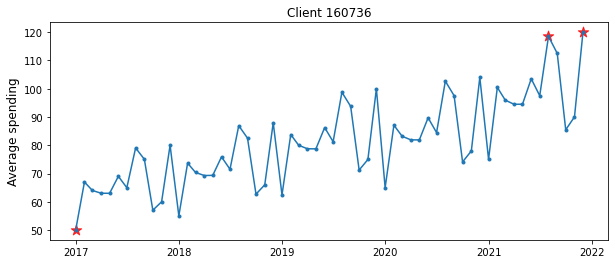

,client_id,date,amount_mean,amount_count
60,160736,2017-01-01,50.047809,5
115,160736,2021-08-01,118.507130,27
119,160736,2021-12-01,119.973821,6


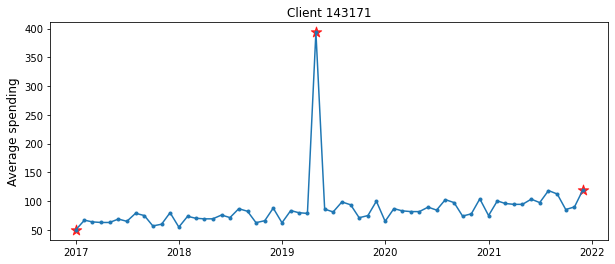

,client_id,date,amount_mean,amount_count
0,143171,2017-01-01,50.059780,6
28,143171,2019-05-01,393.629502,30
59,143171,2021-12-01,119.954088,7


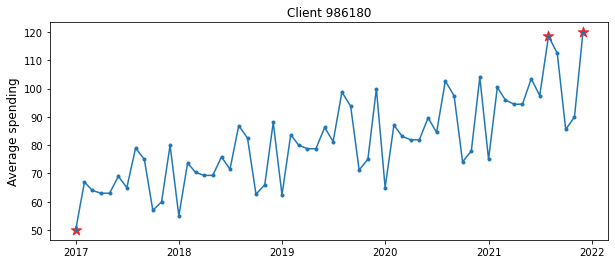

,client_id,date,amount_mean,amount_count
774,986180,2017-01-01,50.054940,2
829,986180,2021-08-01,118.516008,26
833,986180,2021-12-01,119.916524,6


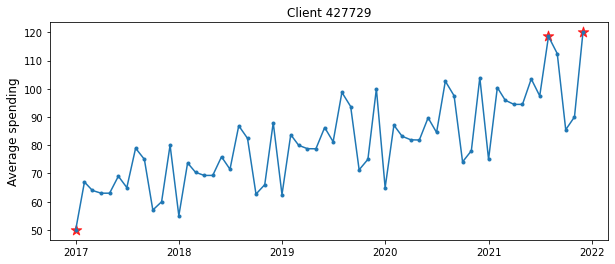

,client_id,date,amount_mean,amount_count
239,427729,2017-01-01,49.994316,5
294,427729,2021-08-01,118.538961,28
298,427729,2021-12-01,120.037550,6


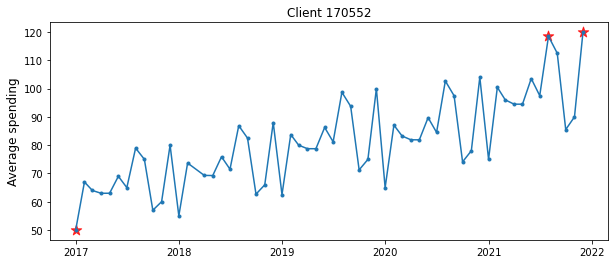

,client_id,date,amount_mean,amount_count
180,170552,2017-01-01,50.041918,6
234,170552,2021-08-01,118.484839,26
238,170552,2021-12-01,119.931829,5


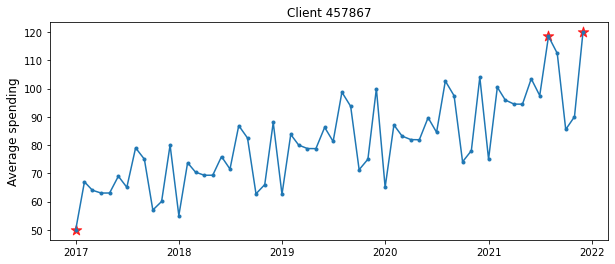

,client_id,date,amount_mean,amount_count
299,457867,2017-01-01,49.933823,5
354,457867,2021-08-01,118.504498,26
358,457867,2021-12-01,119.972596,6


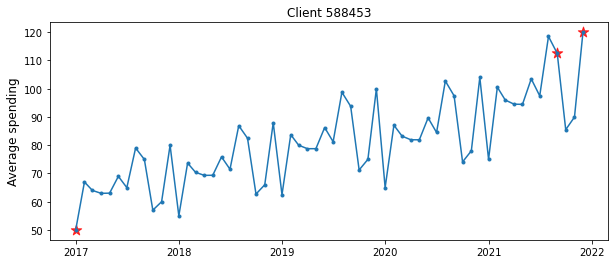

,client_id,date,amount_mean,amount_count
414,588453,2017-01-01,50.023051,5
470,588453,2021-09-01,112.477401,30
473,588453,2021-12-01,119.987704,7


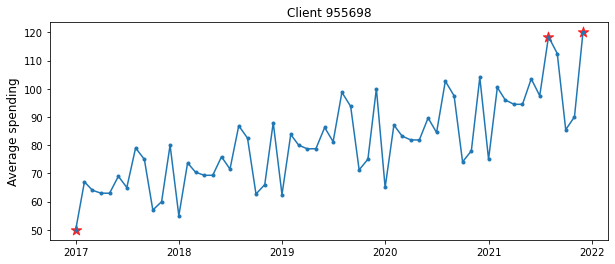

,client_id,date,amount_mean,amount_count
534,955698,2017-01-01,49.949088,5
589,955698,2021-08-01,118.480031,28
593,955698,2021-12-01,120.041505,6


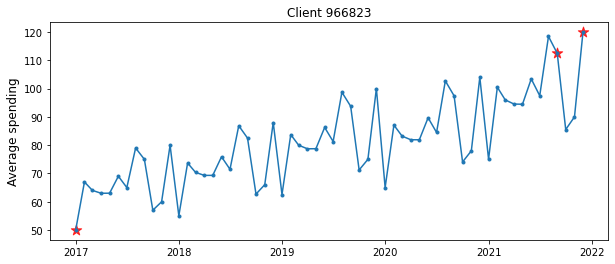

,client_id,date,amount_mean,amount_count
654,966823,2017-01-01,50.019520,5
710,966823,2021-09-01,112.468238,29
713,966823,2021-12-01,119.955770,7


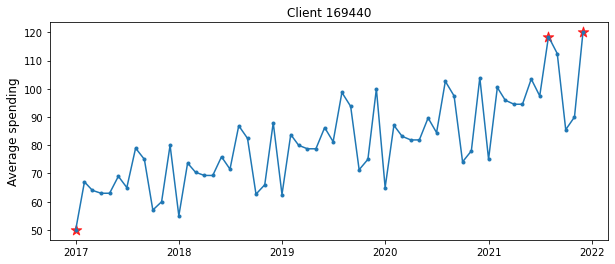

,client_id,date,amount_mean,amount_count
120,169440,2017-01-01,49.986236,6
175,169440,2021-08-01,118.521937,30
179,169440,2021-12-01,120.064968,7


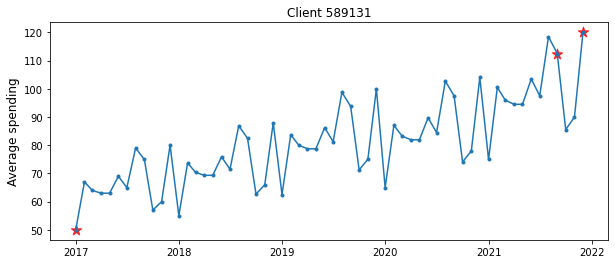

,client_id,date,amount_mean,amount_count
474,589131,2017-01-01,49.986093,5
530,589131,2021-09-01,112.490245,28
533,589131,2021-12-01,120.039410,7


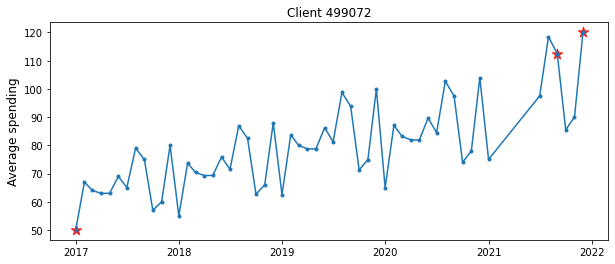

,client_id,date,amount_mean,amount_count
359,499072,2017-01-01,50.039501,5
410,499072,2021-09-01,112.508136,28
413,499072,2021-12-01,120.077164,7


In [167]:
for client in clients:

    # get single client data
    current_client = df[df['client_id'] == client]
    # define model
    model =  IsolationForest(contamination = 0.05)
    # train the model
    model.fit(current_client[['amount_mean']])

    # print(current_client)
    # predict outliers (output -1 is outlier, output 1 is not outlier)
    outliers = np.array(model.predict(current_client[['amount_mean']]))
    # convert output to create filter
    outliers[outliers == 1] = False
    outliers[outliers == -1] = True
    # create filter
    outliers = np.array(outliers, dtype = bool)


    # Plot data with identified residuals
    plt.figure(figsize=(10,4))
    plt.plot(current_client.date, current_client.amount_mean, marker='.')   
    plt.scatter(current_client.loc[outliers].date, current_client.loc[outliers].amount_mean, s = 120, color='r', marker='*', alpha = 0.8, label = "IQR")
    plt.title(f"Client {client}")
    plt.ylabel('Average spending', fontsize=12)
    plt.show()

    # Print outliers in case the have been found
    if outliers.any():
        display(current_client[outliers])

## (S)Arima

The idea in this section is to fit part of the data with SARIMA and forecast the other part. Then compare the results with the test set and based on a threshold identify possible outliers. The downside of this is that the model will be more accurate while more data points we trained it with, which means that we can't identify if there are outliers in those points.

We will take the first two years as training set and the three left for testing.

Needless to say this is a first approach to this method and for better results model tunning should be carried out.

Furthermore we will carried out this analysis for a single client.

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


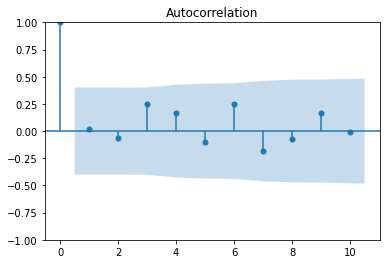

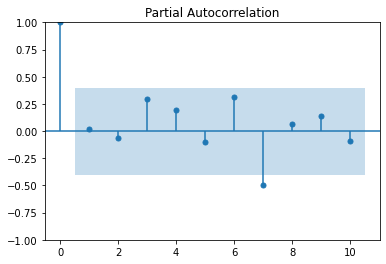

In [268]:
# Get the data from specific client we want to analyze and separate in training and testing.
sp_client = df[df['client_id'] == 499072] # Full data
sp_client_train = df[(df['client_id'] == 499072) & (df['date'].dt.strftime("%Y").isin(['2017','2018']))] # training
sp_client_train_mean = sp_client_train['amount_mean']
sp_client_test = df[(df['client_id'] == 499072) & (df['date'].dt.strftime("%Y").isin([ '2019','2020', '2021']))] # testing

plot_acf(sp_client_train_mean, lags = 10);
plot_pacf(sp_client_train_mean, lags = 10);


c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


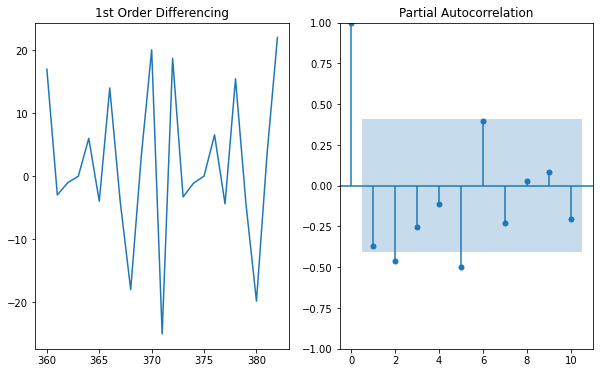

In [269]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(sp_client_train_mean.diff())

ax2 = f.add_subplot(122)
plot_pacf(sp_client_train_mean.diff().dropna(), lags = 10, ax = ax2)
plt.show()

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


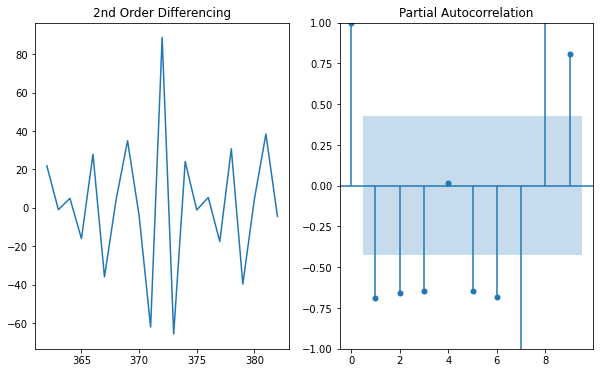

In [270]:
f = plt.figure(figsize=(10,6))
ax1 = f.add_subplot(121)
ax1.set_title('2nd Order Differencing')
ax1.plot(sp_client_train_mean.diff().diff().diff())

ax2 = f.add_subplot(122)
plot_pacf(sp_client_train_mean.diff().diff().diff().dropna(), lags = 9, ax = ax2)
plt.show()

In [271]:
result = adfuller(sp_client_train_mean.dropna())
print('p-value: ', result[1])

result = adfuller(sp_client_train_mean.diff().dropna())
print('p-value: ', result[1])

result = adfuller(sp_client_train_mean.diff().diff().dropna())
print('p-value: ', result[1])

p-value:  0.00022129076135470803
p-value:  4.3164806177305856e-05
p-value:  5.681406360441141e-05


In [272]:
arima_model = SARIMAX(sp_client_train_mean, order=(2,0,1), seasonal_order = (1,0,3,12))
model = arima_model.fit()
print(model.summary())

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few obs

                                         SARIMAX Results                                          
Dep. Variable:                                amount_mean   No. Observations:                   24
Model:             SARIMAX(2, 0, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                 -65.064
Date:                                    Wed, 30 Nov 2022   AIC                            146.128
Time:                                            00:03:39   BIC                            155.552
Sample:                                                 0   HQIC                           148.628
                                                     - 24                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7751      0.395      1.963      0

c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Luis\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


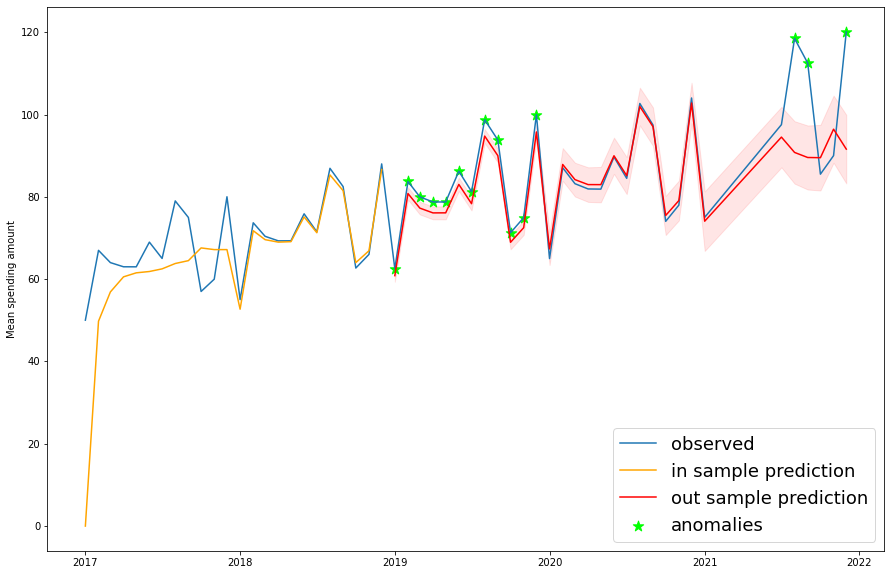

In [297]:
# define start and end points for intervals used in prediction
start_out = len(sp_client_train)
end_out = len(sp_client_train) + len(sp_client_test) - 1
start_in = 0
end_in = len(sp_client_train) - 1

# Predict in sample and outsample
in_sample_prediction = model.predict(start=start_in, end=end_in, dynamic = False, typ='levels')
out_sample_prediction = model.predict(start=start_out, end=end_out, dynamic = False, typ='levels') # same as forecast(len(test_set))

# Get confidence interval
lower_ci = model.get_forecast(len(sp_client_test)).summary_frame().mean_ci_lower
upper_ci = model.get_forecast(len(sp_client_test)).summary_frame().mean_ci_upper

# Define filter to find outliers
filter = [True if ((sp_client_test['amount_mean'].iloc[i] > upper_ci.iloc[i]) | 
          (sp_client_test['amount_mean'].iloc[i] < lower_ci.iloc[i])) else False 
          for i in range(len(sp_client_test))]


# plot observed data, in and out sample predictions and confidence intervals
plt.figure(figsize=(15,10))
plt.plot(sp_client['date'], sp_client['amount_mean'], label='observed')
plt.plot(sp_client_train['date'], in_sample_prediction, color = 'orange', label = 'in sample prediction')
plt.plot(sp_client_test['date'], out_sample_prediction, color = 'red', label = 'out sample prediction')
plt.fill_between(sp_client_test['date'], lower_ci, upper_ci, color='red', alpha=0.1)
plt.scatter(sp_client_test.loc[filter]['date'], sp_client_test.loc[filter]['amount_mean'], s = 120, color='lime', marker='*', label = "anomalies")
plt.ylabel("Mean spending amount")
plt.legend(prop={'size': 18}, loc = "lower right")
plt.show()



# General focus

For this first part we are not having into account the different clients, but we work with the whole history of transactions, indepently of who made it in particular. This is just a short first approach, because it is actually not very robust in the sense that clients have independent behaviors and we should analyze them separately. If only a small percentage of clients present anomalies, these may not show in the general data, because their effect has been diminished. 

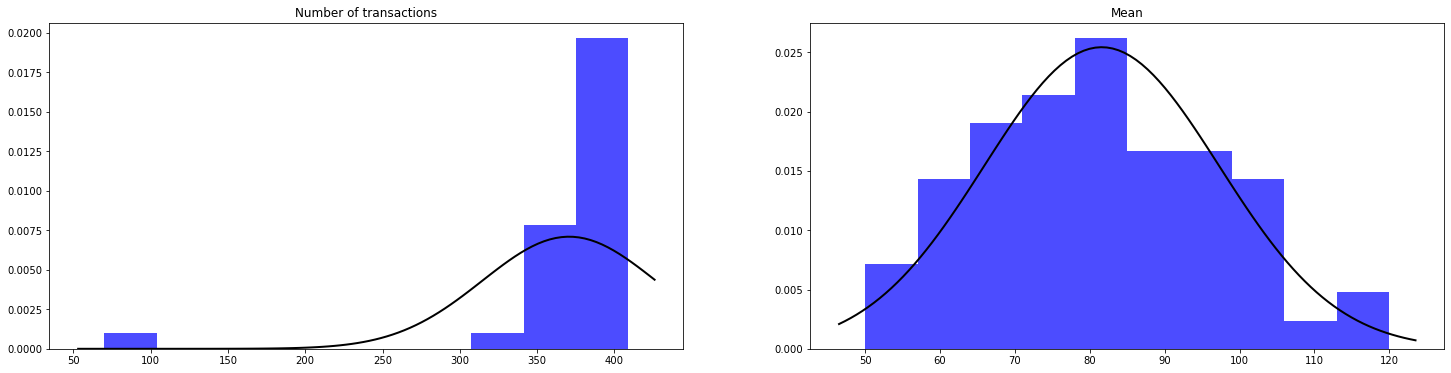

In [156]:
def get_pdf(dataframe, column, xmin, xmax):
    """
    Calculates and returns normal distribution of a given pandas series. 

    Inputs:
    :dataframe: dataframe.
    :column: column of the data frame from which we want to calculate gaussian distribution. 
    :xmin: integer. Minimum value of the x axis for the future plot.
    :xmax: integer. Maximum value of the x axis for the future plot.

    Outputs:
    :x: array of values for the x axis of future plot
    :p: normal distribution of the input data.

    """


    mu, std = norm.fit(dataframe[column])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    return x, p



f = plt.figure(figsize=(25,6))

ax1 = f.add_subplot(121)
# Plot the histogram.
ax1.hist(df_all['amount_count'], density=True, alpha=0.7, color='b')
# Plot the PDF.
xmin, xmax = plt.xlim()
x, p = get_pdf(df_all, 'amount_count', xmin, xmax)
ax1.plot(x, p, 'k', linewidth=2)
ax1.set_title('Number of transactions')


ax2 = f.add_subplot(122)
# Plot the histogram.
ax2.hist(df_all['amount_mean'], density=True, alpha=0.7, color='b')
# Plot the PDF.
xmin, xmax = plt.xlim()
x, p = get_pdf(df_all, 'amount_mean', xmin, xmax)
ax2.plot(x, p, 'k', linewidth=2)
ax2.set_title('Mean')


plt.show()

There are some low values, but these could be the starting and ending months, for which we don't have the full data. Let's investigate further.

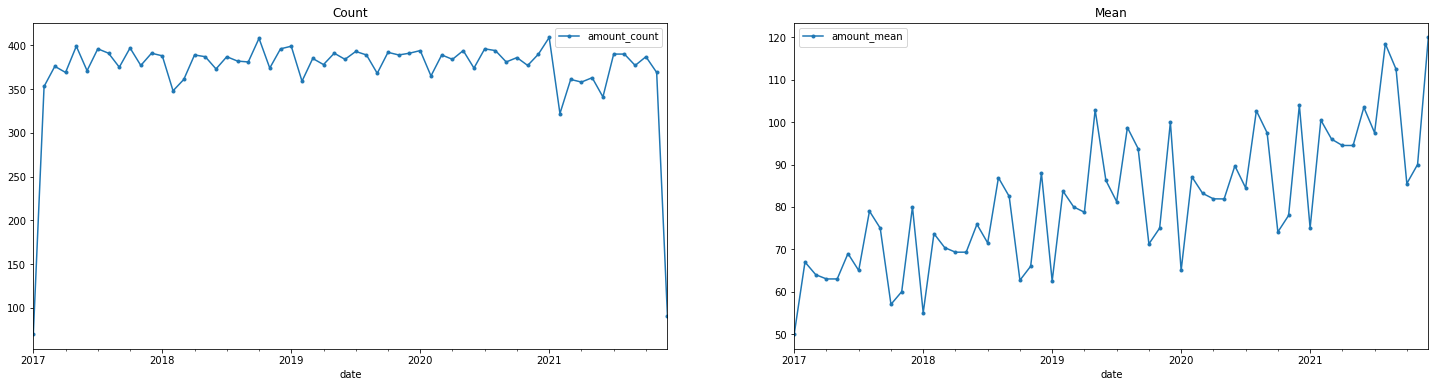

In [157]:
f = plt.figure(figsize=(25,6))

ax1 = f.add_subplot(121)
df_all.plot(x= 'date', y= 'amount_count', ax = ax1, marker='.')
ax1.set_title('Count')

ax2 = f.add_subplot(122)
df_all.plot(x= 'date', y= 'amount_mean', ax = ax2, marker='.')
ax2.set_title('Mean')

plt.show()

As suspected, the starting and ending months have the lowest count, and the reason may be because we don't have the full month data.

## Check boxplots

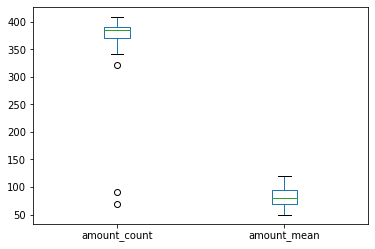

In [158]:
boxplot = df_all.boxplot(column=['amount_count', 'amount_mean'], grid=False)


There seem to be no outliers in the mean amount. For the counts we have the two previously studied points and an additional one. However, the count is less than what is expected and for our purpose it might not represent a danger.

## STL decomposition

##################################################
################### Client All ###################
##################################################
***********Anomalies found with z-score***********


date
2019-05-01    102.907602
Name: amount_mean, dtype: float64

*************Anomalies found with IQR*************


date
2018-05-01     69.319691
2019-05-01    102.907602
2019-12-01     99.991512
2020-05-01     81.884656
Name: amount_mean, dtype: float64

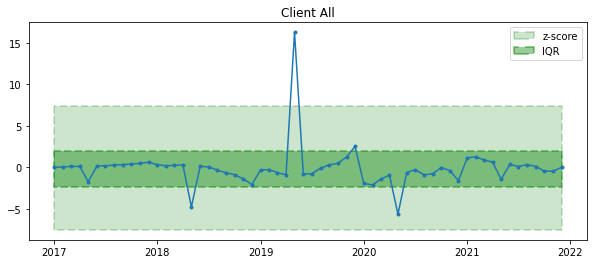

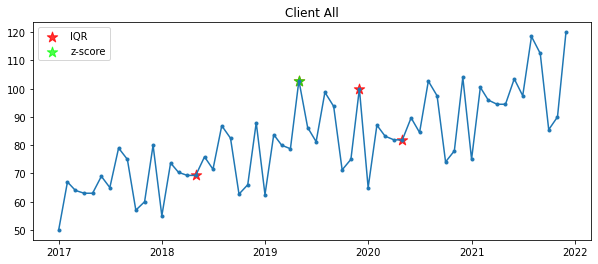

In [ ]:
all_df = df_all.set_index('date')['amount_mean']

stl = STL(all_df, period = 12)
result = stl.fit()
resid = result.resid

find_anomalies(all_df, resid, "All")

# Tests and dont-want-to-delete-code

In [517]:
df2 = pd.DataFrame([[1, 2, 3, 4, 100], ['A','B','C','C','C'], ['Luis', 'Laia', 'Eco', 'Luis', 'Luis']]).T
df2.columns = ['amount','letter','name']
df2



df3 = df2.groupby(by=['name', 'letter'], as_index = False).count() # also consider median and mean
df3

,name,letter,amount
0,Eco,C,1
1,Laia,B,1
2,Luis,A,1
3,Luis,C,2


In [ ]:
# plt.figure(figsize=(8,6))

# plt.subplot(4,1,1)
# plt.plot(my_client)
# plt.title('Original Series', fontsize=16)

# plt.subplot(4,1,2)
# plt.plot(trend)
# plt.title('Trend', fontsize=16)

# plt.subplot(4,1,3)
# plt.plot(seasonal)
# plt.title('Seasonal', fontsize=16)

# plt.subplot(4,1,4)
# plt.plot(resid)
# plt.title('Residual', fontsize=16)

# plt.tight_layout()





# estimated = trend + seasonal
# plt.figure(figsize=(12,4))
# plt.plot(my_client)
# plt.plot(estimated)